# Stationarity of Weather Dataset
This notebook demonstrates the application of various methods to detect stationarity for each signal in the Weather Dataset. It includes rolling mean, ACF, PACF plots, ADF, and KPSS tests.

In [1]:
#import libraries
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.api import OLS
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.impute import SimpleImputer

Necessary functions.


In [2]:
#function to plot a roling statistics

def plot_rolling_statistics(df, file_name, window=12):
    """
    Plots the rolling statistics of a time series, including the original data and the rolling mean.

    Parameters:
    - df (DataFrame): The DataFrame containing the time series data.
    - file_name (str): A string representing the name or description of the data for the plot title.
    - window (int, optional): The window size for calculating the rolling mean. Default is set to 12.
    """
    series = df['value']
    rolling_mean = series.rolling(window=window).mean()
    #rolling_std = series.rolling(window=window).std()

    plt.figure(figsize=(16, 10))
    plt.plot(series, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    #plt.plot(rolling_std, label='Rolling Std')
    plt.title(f'Rolling Mean {file_name}')
    #plt.title(f'Rolling Mean & Standard Deviation {file_name}')
    plt.xlabel('timestamp')
    plt.ylabel('value')
    plt.legend()
    plt.show()

In [3]:
# Function to plot ACF and PACF
def plot_acf_pacf(series,file_name):
    """
    Plots the AutoCorrelation Function (ACF) and Partial AutoCorrelation Function (PACF) of a time series.

    Parameters:
    - series (Series): A pandas Series containing the time series data.
    - file_name (str): A string representing the name or description of the data for the plot titles.
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(series, ax=plt.gca(), lags=None)  # Automatically determine the number of lags
    plt.title(f'ACF {file_name}')

    plt.subplot(122)
    plot_pacf(series, ax=plt.gca(), lags=None) # Automatically determine the number of lags
    plt.title(f'PACF {file_name}')
    plt.tight_layout()
    plt.show()

In [4]:
#Augmented Dickey Fuller unit root for time series Stationarity. 
#After the changeing of regression parameter we can test different types of stationarity
#c - constant only
#ct - constant and trend
#ctt - constant and quadratic trend
#n - no constant, no trend
def adf_test(series, reg ='c'):
    """
    Performs the Augmented Dickey-Fuller (ADF) test for stationarity.

    Parameters:
    - series (array-like): The time series data to be tested for stationarity.
    - reg (str, optional): The type of regression used in the ADF test. 'c' (default) indicates stationary around a constant.
                           'ct' indicates stationary around a constant and trend.

    Returns:
    - AD_Test (tuple): A tuple containing the ADF test results including the ADF statistic, p-value, number of lags, and critical values.
    """

    #series = df.loc[:, 'value'].values
    AD_Test = adfuller(series, regression=reg, autolag='AIC')
    return AD_Test

# Function to print core information from Augmented Dickey Fuller Test
def print_adf_results(AD_Test):
    """
    Prints the core information obtained from the Augmented Dickey-Fuller (ADF) test.

    Parameters:
    - AD_Test (tuple): A tuple containing the ADF test results.

    """
    print(f'ADF Statistic: {AD_Test[0]}')
    print(f'p-value: {AD_Test[1]}')
    print(f'n_lags: {AD_Test[2]}')
    print(f'Number of observations:{AD_Test[3]}')
    for key, value in AD_Test[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

In [5]:
#Kwiatkowski Phillips Schmidt Test
#After the changeing of Regressions parameter we can test different types of stationarity
#c - data is stationary around constant
#ct - data is stationary around constant and trend
def kpss_test(series,reg = 'c'):
    """
    Performs the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for stationarity.

    Parameters:
    - series (array-like): The time series data to be tested for stationarity.
    - reg (str, optional): The type of regression used in the KPSS test. 'c' (default) indicates stationary around a constant.
                          'ct' indicates stationary around a constant and trend.

    Returns:
    - KPSS_test (tuple): A tuple containing the KPSS test results including the KPSS statistic, p-value, number of lags, and critical values.
    """
    #series = df.loc[:, 'value'].values
    KPSS_test = kpss(series, regression=reg)
    return KPSS_test


#Function to print the core information from Kwiatkowski Phillips Schmidt Test
def print_kpss_results(KPSS_test):
    """
    Prints the core information obtained from the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test.

    Parameters:
    - KPSS_test (tuple): A tuple containing the KPSS test results.

    """
    print(f'ADF Statistic: {KPSS_test[0]}')
    print(f'p-value: {KPSS_test[1]}')
    print(f'n_lags: {KPSS_test[2]}')
    for key, value in KPSS_test[3].items():
        print('Critial Values:')
        print(f'   {key}, {value}')  

In [6]:
def print_information_about_file(df, file_name):
    """
    Prints information about a time series dataset including rolling statistics, ADF test results, KPSS test results, and ACF/PACF plots.

    Parameters:
    - df (DataFrame): The DataFrame containing the time series data.
    - file_name (str): A string representing the name or description of the data for the printed information.
    """
    print(f'information about: {file_name}')
    #extract the series values
    series = df.loc[:, 'value'].values
    plot_rolling_statistics(df,file_name)
    #perform Tests
    AD_Test = adf_test(series)
    KPSS_test = kpss_test(series)
    #print ADF test results
    print_adf_results(AD_Test)
    print_kpss_results(KPSS_test)
    #plot ACF and PACF
    plot_acf_pacf(series,file_name)

In [7]:
#process fill and add to summary data Frame
#This function calculates various statistics and test results for a given time series dataset and appends them to an existing summary DataFrame.
#The summary includes the dataset's length, ADF test statistics (ADF Statistic, p-value, lags, critical values), and KPSS test statistics (KPSS Statistics, p-value, critical values).
def create_summary_frame(df_info, df ,file_name,regression_ADF,regression_KPSS):
    length = len(df)
    adf_result = adf_test(df['value'], regression_ADF)
    adf_statistic, adf_pvalue,adf_lags = adf_result[:3]
    adf_5_percent_critical_value, adf_10_percent_critical_value = adf_result[4]['5%'], adf_result[4]['10%']
    kpss_results = kpss_test(df['value'], regression_KPSS)
    kpss_statistics, kpss_pvalue = kpss_results[:2]
    kpss_5_percent_critical_value, kpss_10_percent_critical_value = kpss_results[3]['5%'], kpss_results[3]['10%']

    df_info = df_info.append({'File Name': file_name,
                              'Length': length,
                              'ADF Statistic': adf_statistic,
                              'ADF Regression': regression_ADF,  
                              'ADF p-value': adf_pvalue,
                              'ADF lags': adf_lags,
                              'ADF Critical Value 10%': adf_10_percent_critical_value,
                              'ADF Critical Value 5%': adf_5_percent_critical_value,
                              'KPSS Statistics': kpss_statistics,
                              'KPSS Regression': regression_KPSS,
                              'KPSS p-value': kpss_pvalue,
                              'KPSS Critical Value 10%': kpss_10_percent_critical_value,
                              'KPSS Critical Value 5%': kpss_5_percent_critical_value},
                             ignore_index=True)
    return df_info

## Compute statistics for different collections of Weather Dataset
A summary is stored in a separate DataFrame (and saved as .csv file) for temperature and pressure collection of the Weather Dataset.

Temperature collection

In [8]:
#create a new info_frame
columns = ['File Name', 'Length', 'ADF Statistic', 'ADF Regression', 'ADF p-value', 'ADF lags', 'ADF Critical Value 10%', 'ADF Critical Value 5%', 'KPSS Statistics', 'KPSS Regression', 'KPSS p-value', 'KPSS Critical Value 10%', 'KPSS Critical Value 5%']
df_info = pd.DataFrame(columns=columns)
regression_ADF_values = ['c', 'n', 'ct', 'ctt']
regression_KPSS_values = ['c', 'c', 'ct', 'ct']

information about: daily_temperature_Bamberg.csv


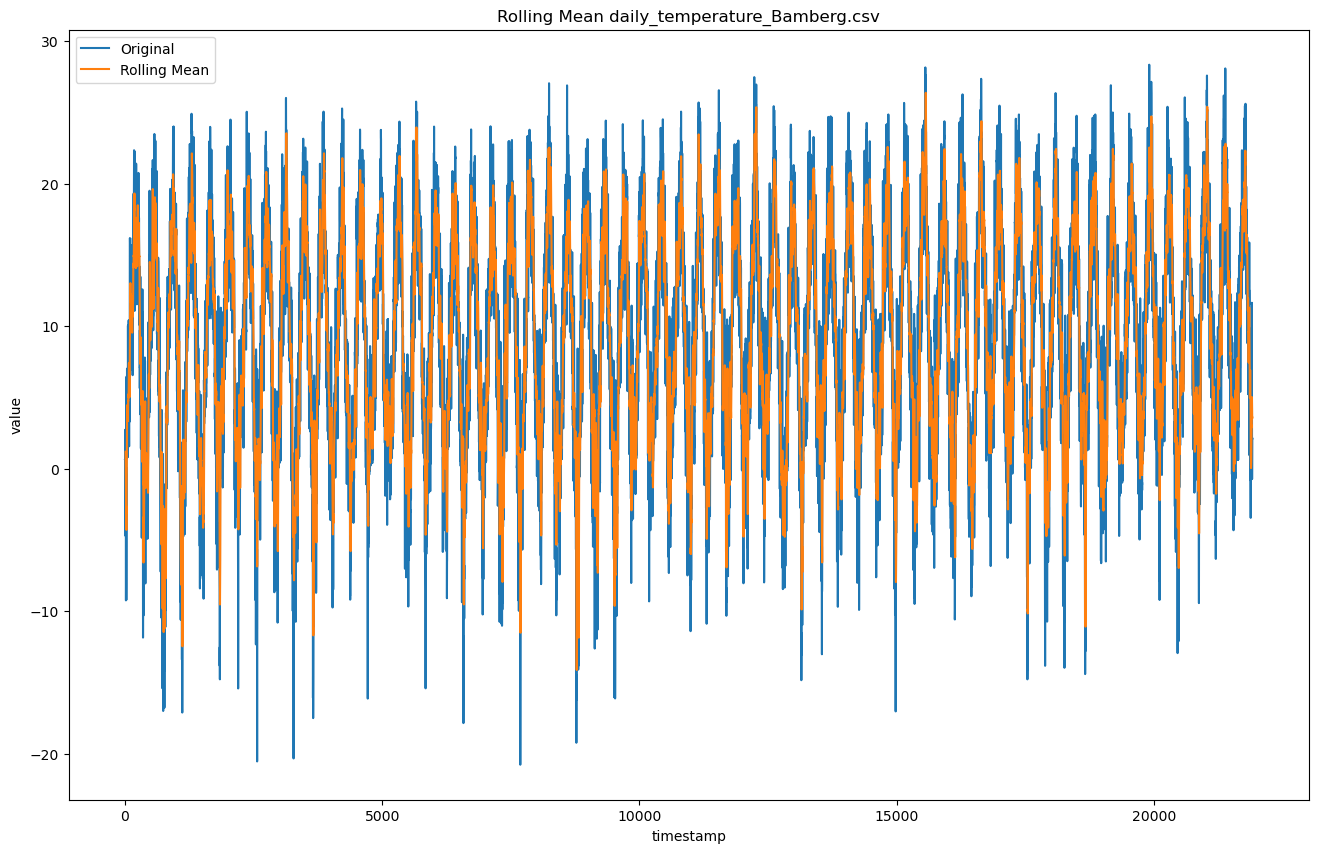

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -11.233439586022024
p-value: 1.8826320802650346e-20
n_lags: 47
Number of observations:21864
Critical Values:
   1%, -3.430649124950248
Critical Values:
   5%, -2.8616722033358686
Critical Values:
   10%, -2.5668403681154426
ADF Statistic: 0.2654159214267894
p-value: 0.1
n_lags: 88
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


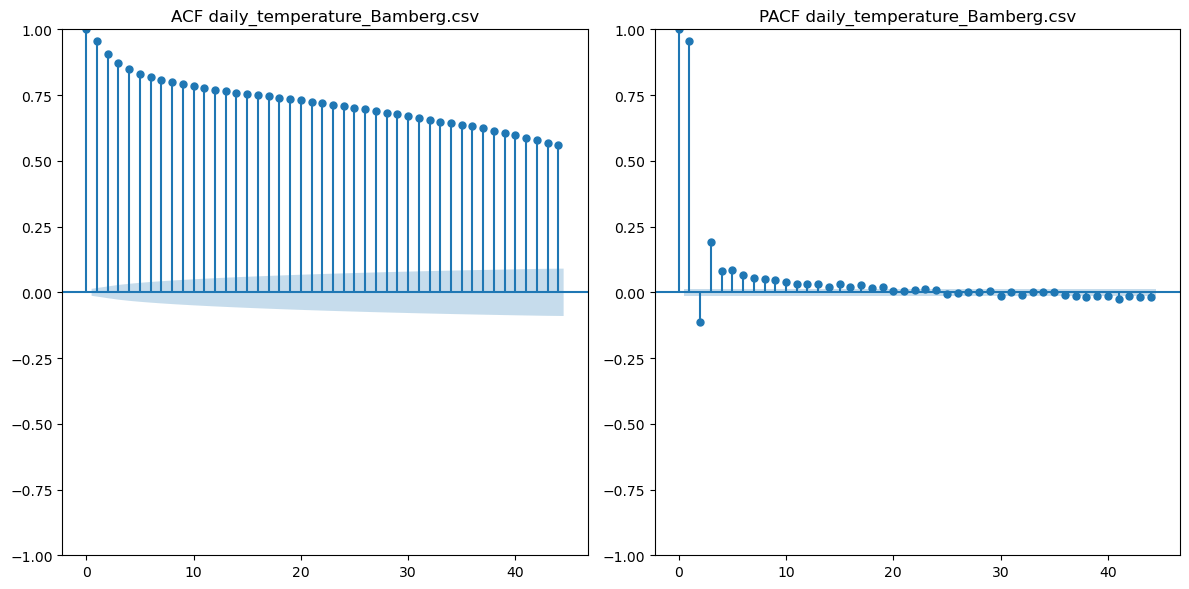

information about: daily_temperature_Bamberg_1981-1990.csv


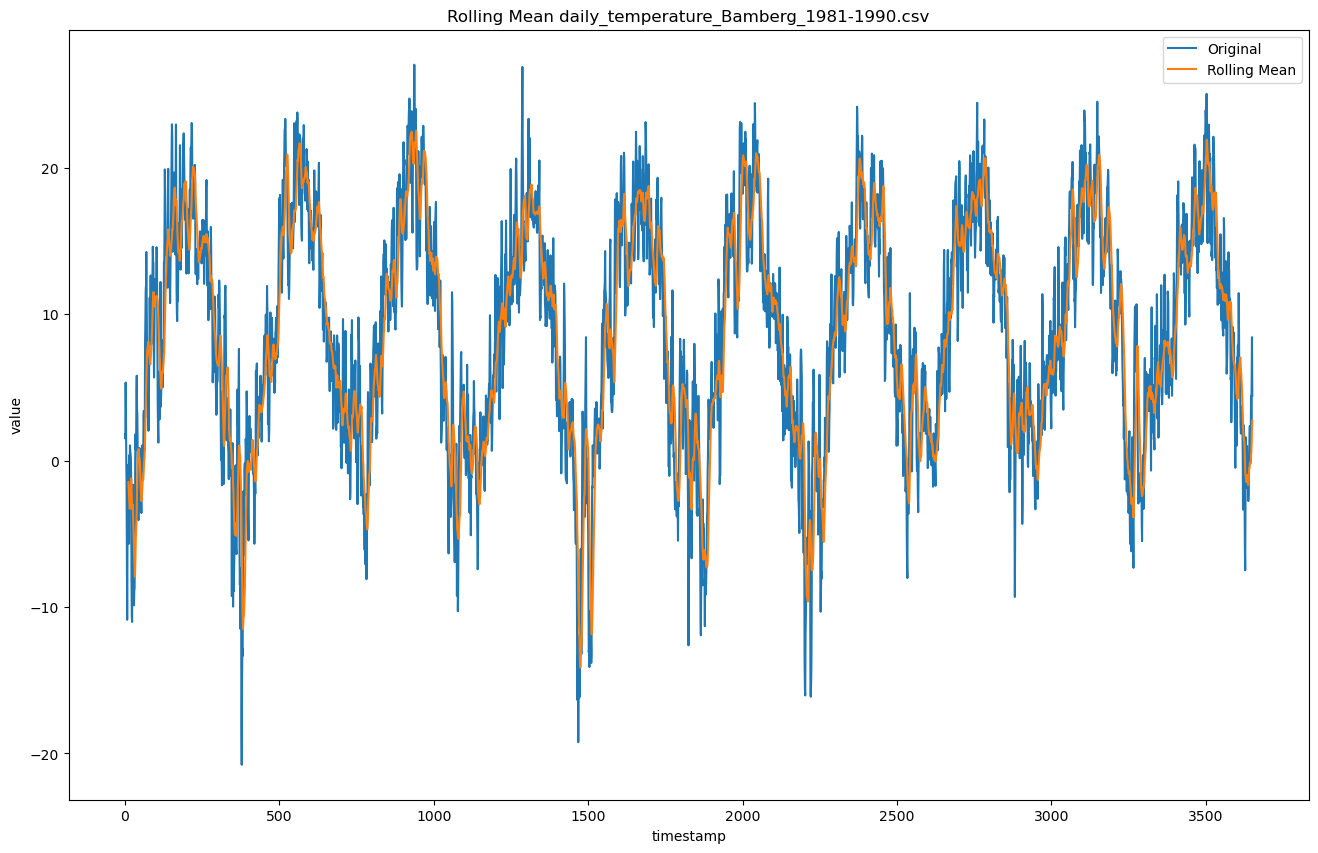

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -4.408536523873842
p-value: 0.00028667543028363507
n_lags: 16
Number of observations:3635
Critical Values:
   1%, -3.432150254165979
Critical Values:
   5%, -2.8623354519441797
Critical Values:
   10%, -2.567193431297053
ADF Statistic: 0.0754205589108631
p-value: 0.1
n_lags: 37
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


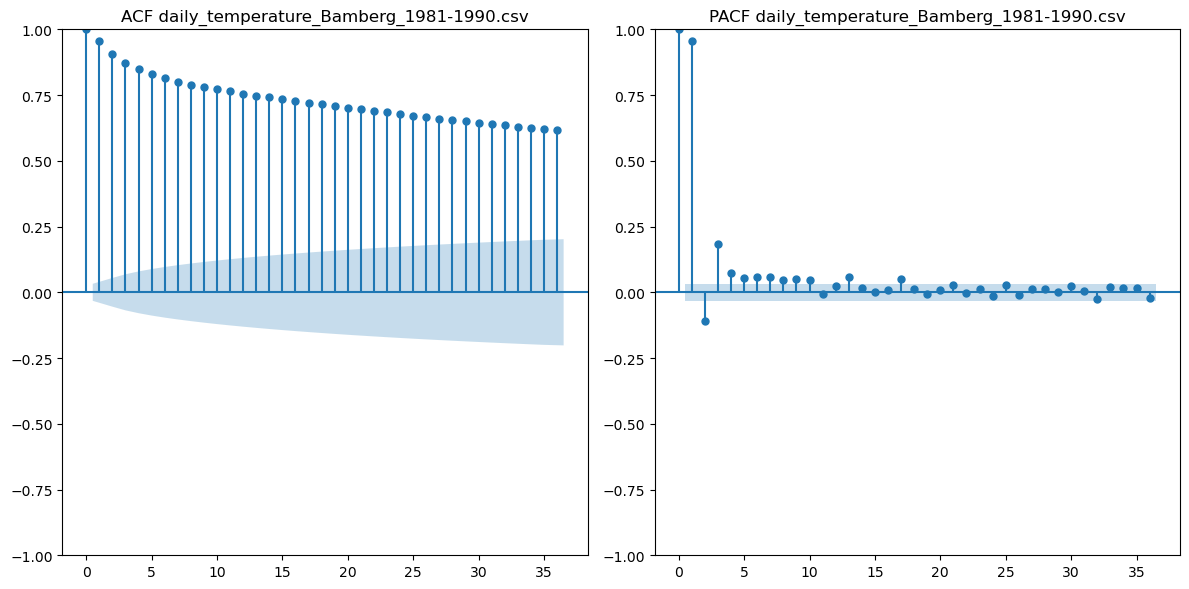

information about: daily_temperature_Bamberg_1961-1970.csv


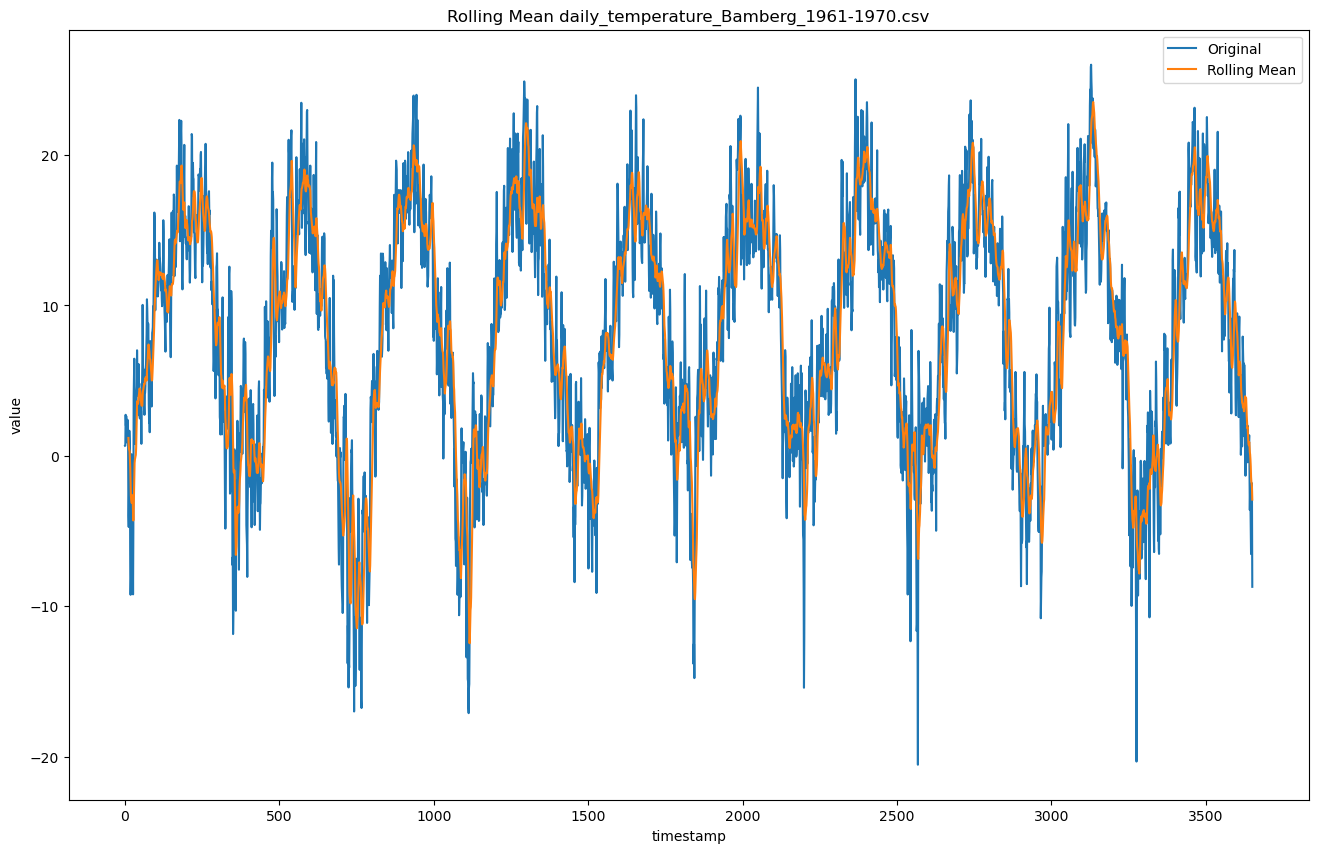

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -3.691032061950976
p-value: 0.004241079163744021
n_lags: 18
Number of observations:3633
Critical Values:
   1%, -3.4321512459240684
Critical Values:
   5%, -2.862335890025229
Critical Values:
   10%, -2.5671936645169833
ADF Statistic: 0.04346918501152263
p-value: 0.1
n_lags: 37
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


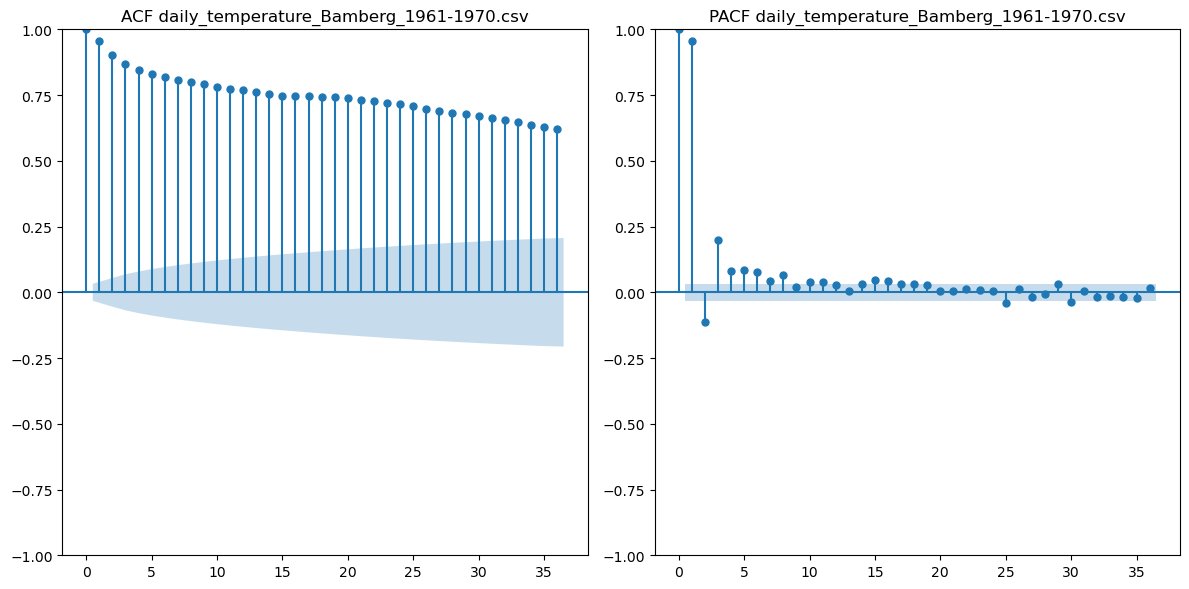

information about: daily_temperature_Bamberg_2011-2020.csv


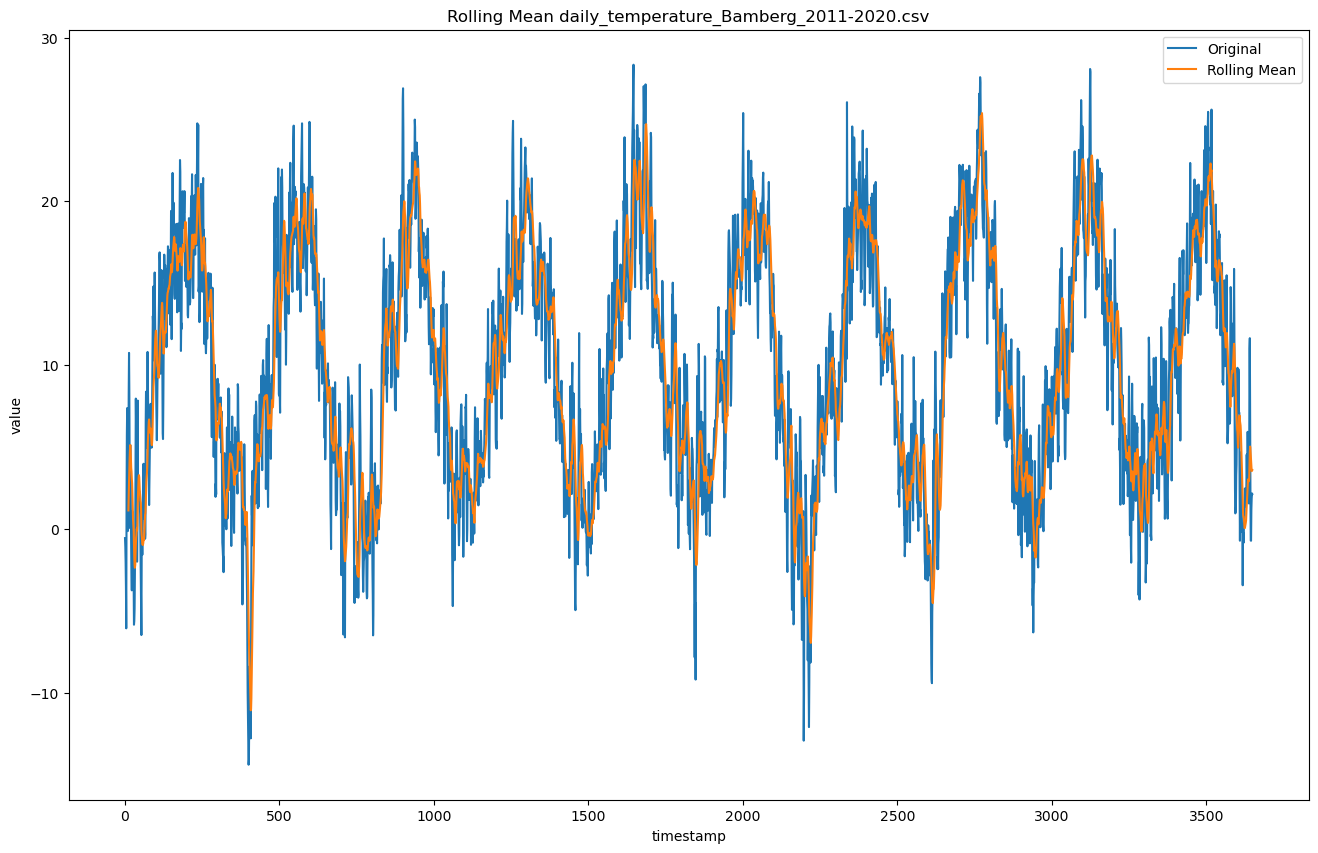

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -3.574428453163948
p-value: 0.006269145542678526
n_lags: 19
Number of observations:3630
Critical Values:
   1%, -3.432152735611742
Critical Values:
   5%, -2.8623365480522964
Critical Values:
   10%, -2.567194014828981
ADF Statistic: 0.06714355376738312
p-value: 0.1
n_lags: 37
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


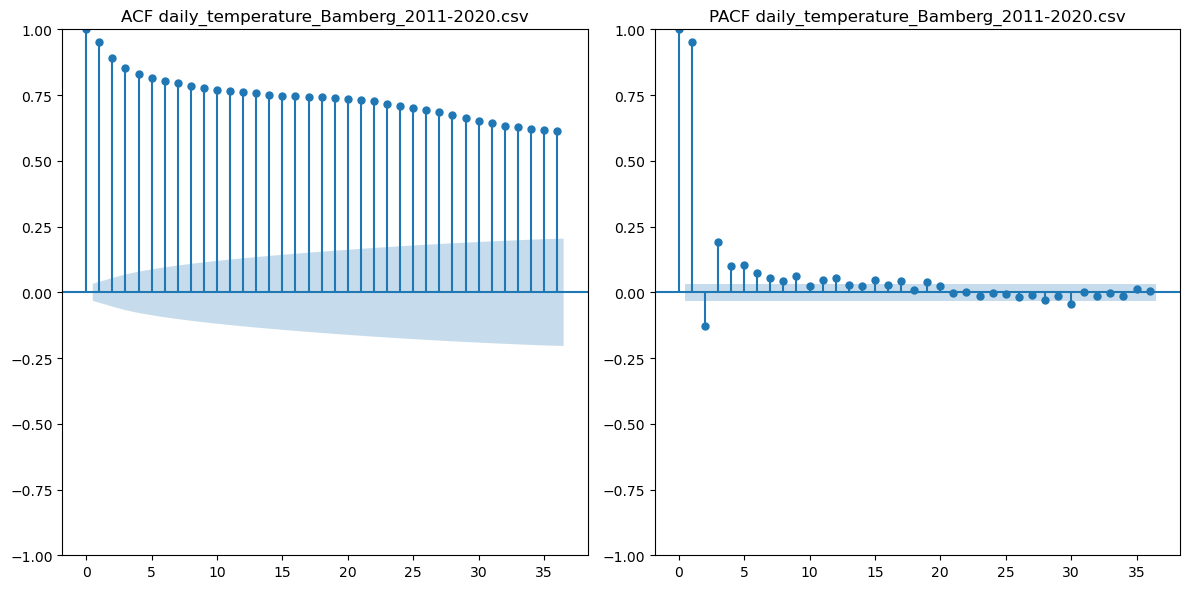

information about: daily_temperature_test1.csv


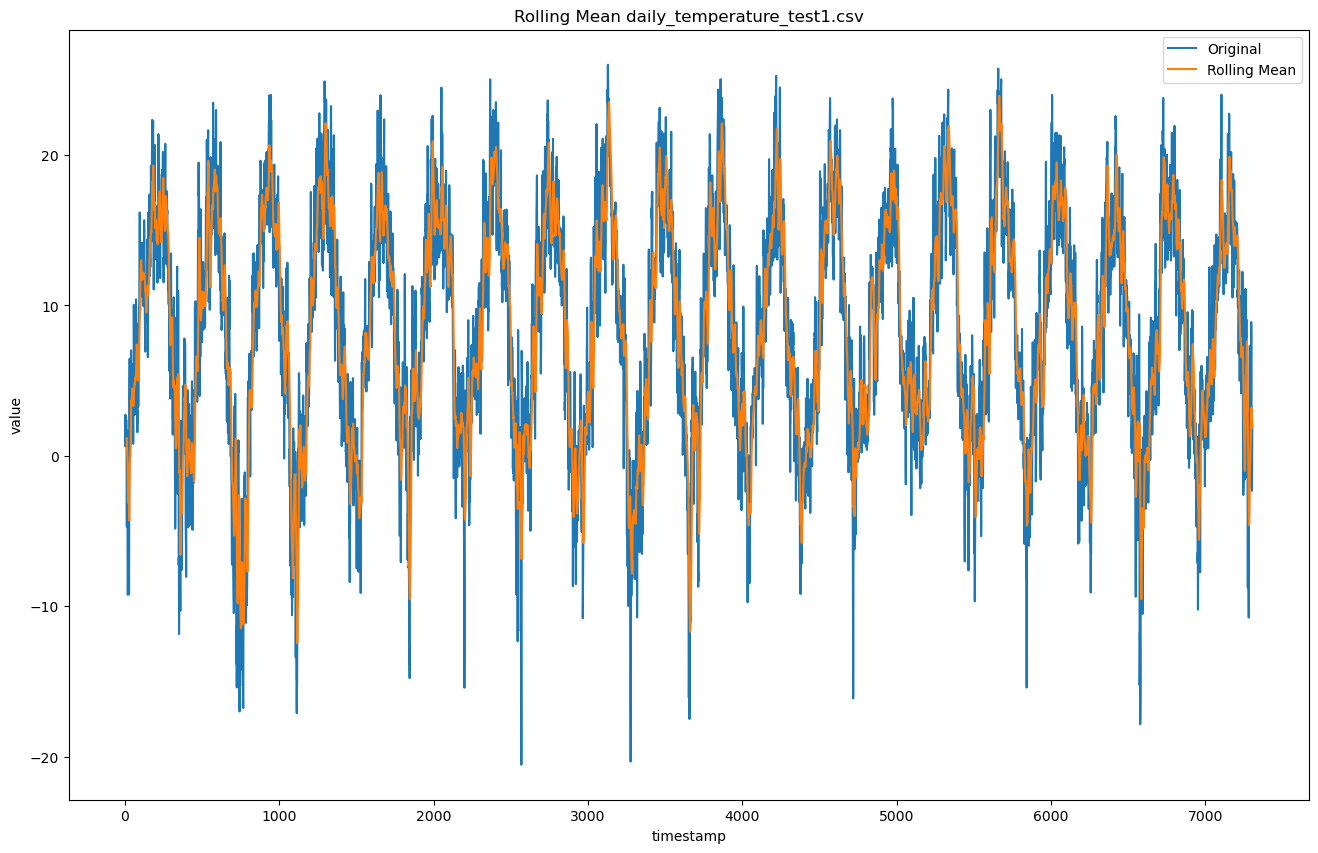

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -5.603896921984047
p-value: 1.246816870969719e-06
n_lags: 18
Number of observations:7286
Critical Values:
   1%, -3.4312478321941735
Critical Values:
   5%, -2.861936772147779
Critical Values:
   10%, -2.5669811975753363
ADF Statistic: 0.0269784606803817
p-value: 0.1
n_lags: 52
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


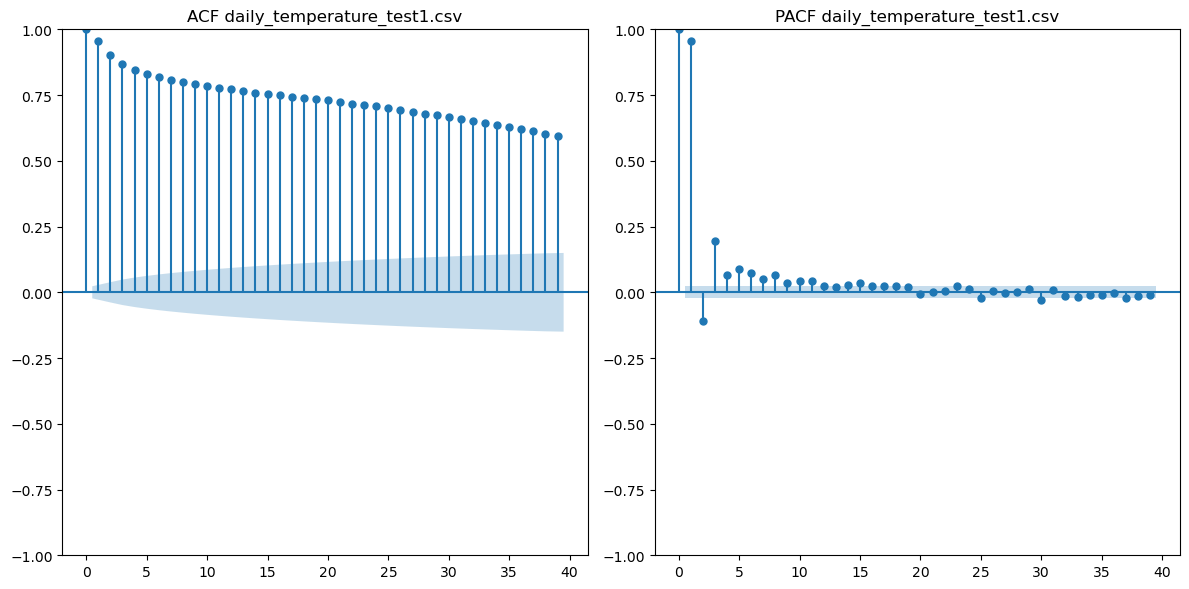

information about: daily_temperature_training.csv


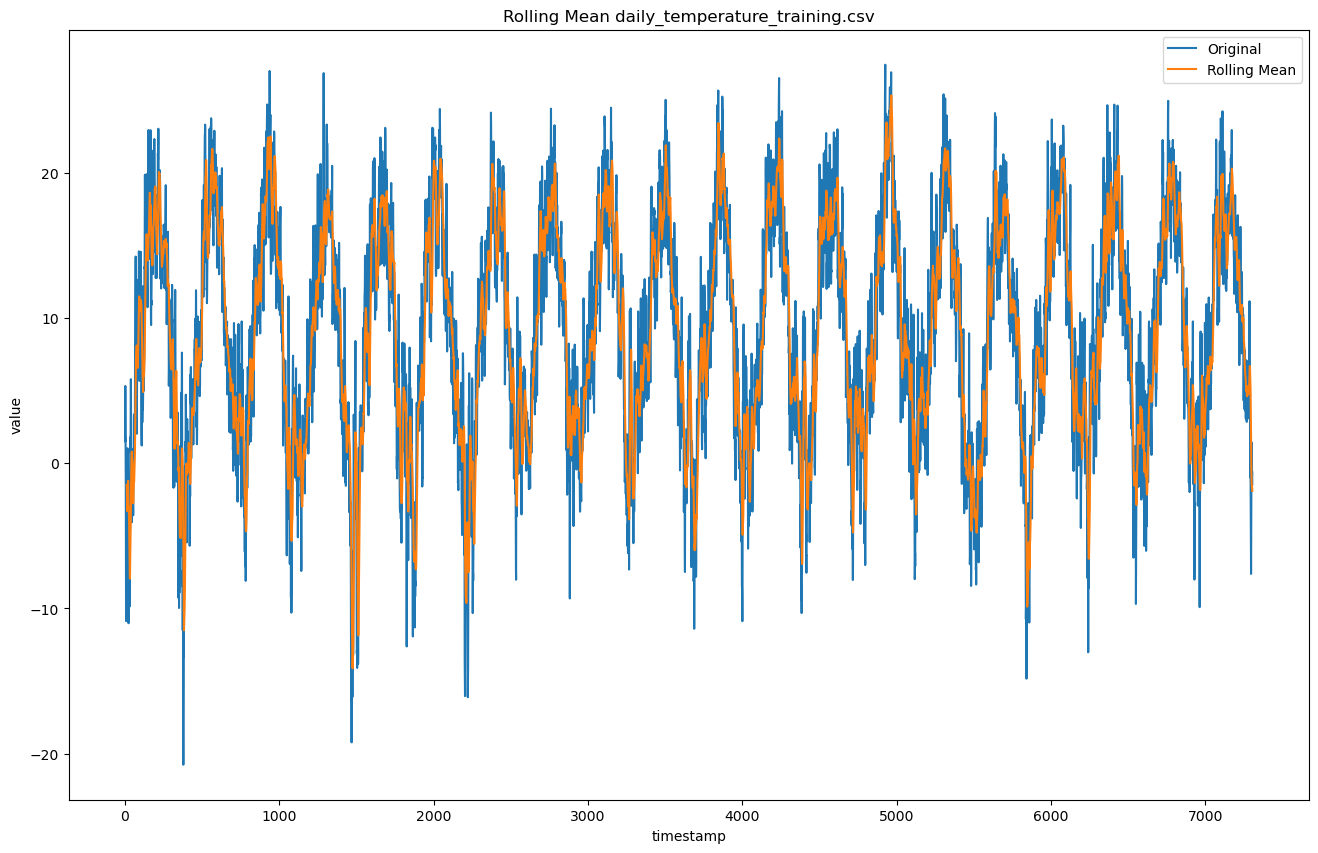

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -6.025104993033541
p-value: 1.462284021510252e-07
n_lags: 16
Number of observations:7288
Critical Values:
   1%, -3.4312475857208686
Critical Values:
   5%, -2.861936663242156
Critical Values:
   10%, -2.566981139603197
ADF Statistic: 0.07231678728009154
p-value: 0.1
n_lags: 52
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


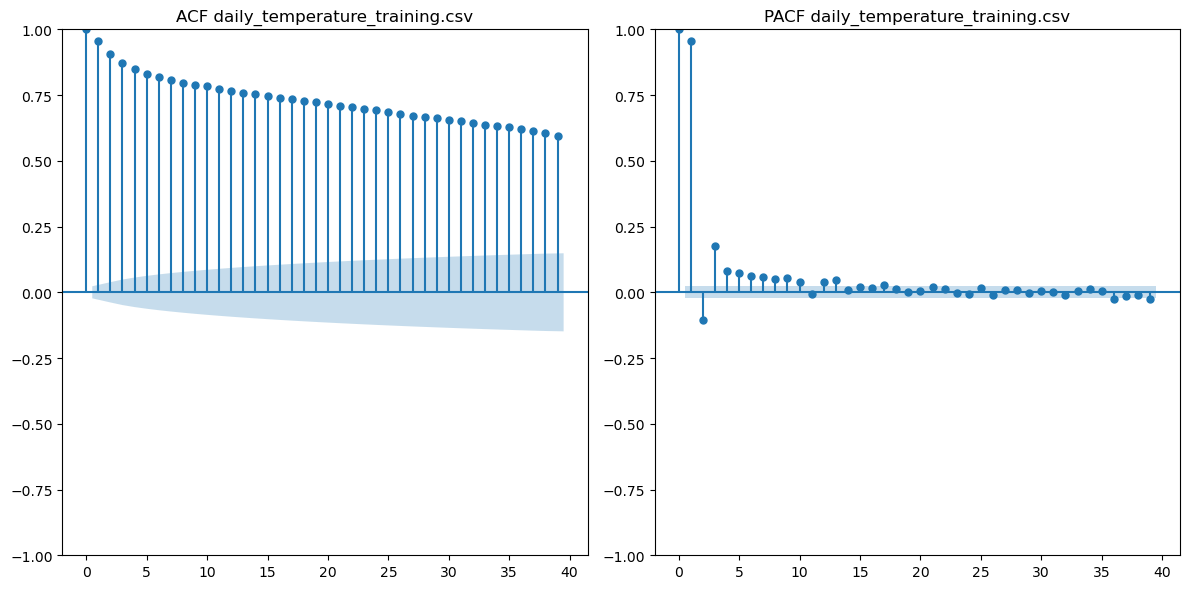

information about: daily_temperature_test2.csv


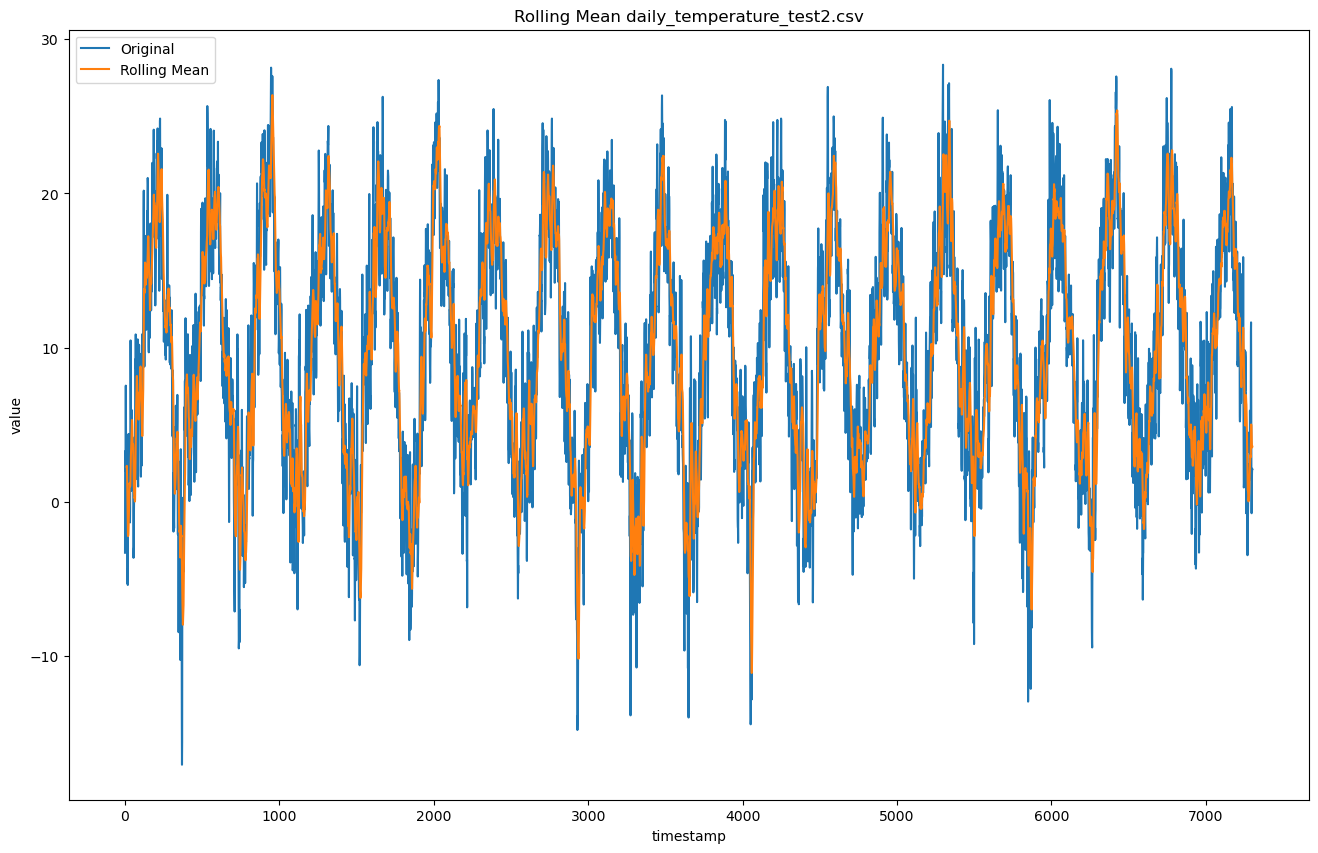

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -5.519715826057125
p-value: 1.8896646686674334e-06
n_lags: 18
Number of observations:7283
Critical Values:
   1%, -3.4312482021580375
Critical Values:
   5%, -2.861936935618387
Critical Values:
   10%, -2.5669812845932594
ADF Statistic: 0.03289206375882926
p-value: 0.1
n_lags: 52
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


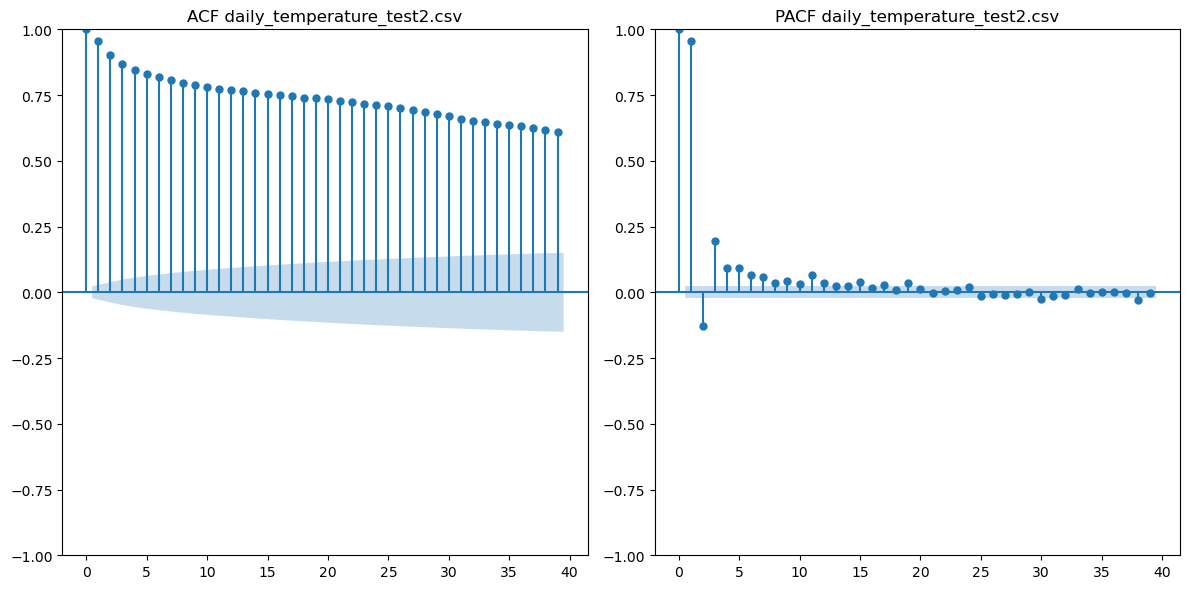

information about: daily_temperature_Bamberg_2001-2010.csv


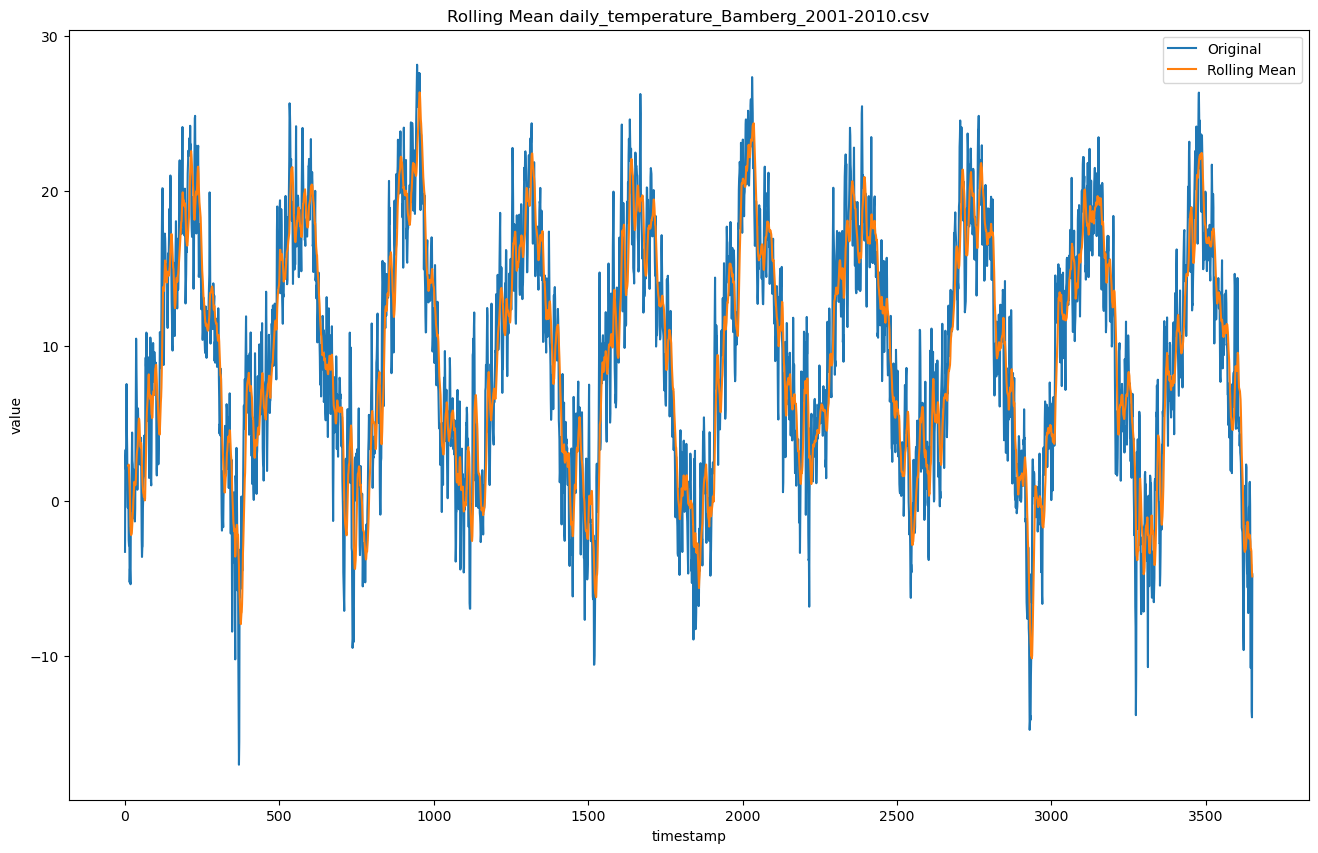

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -3.4214324293573877
p-value: 0.010249582171920568
n_lags: 23
Number of observations:3628
Critical Values:
   1%, -3.432153730106524
Critical Values:
   5%, -2.8623369873418363
Critical Values:
   10%, -2.567194248692334
ADF Statistic: 0.03372776617321193
p-value: 0.1
n_lags: 37
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


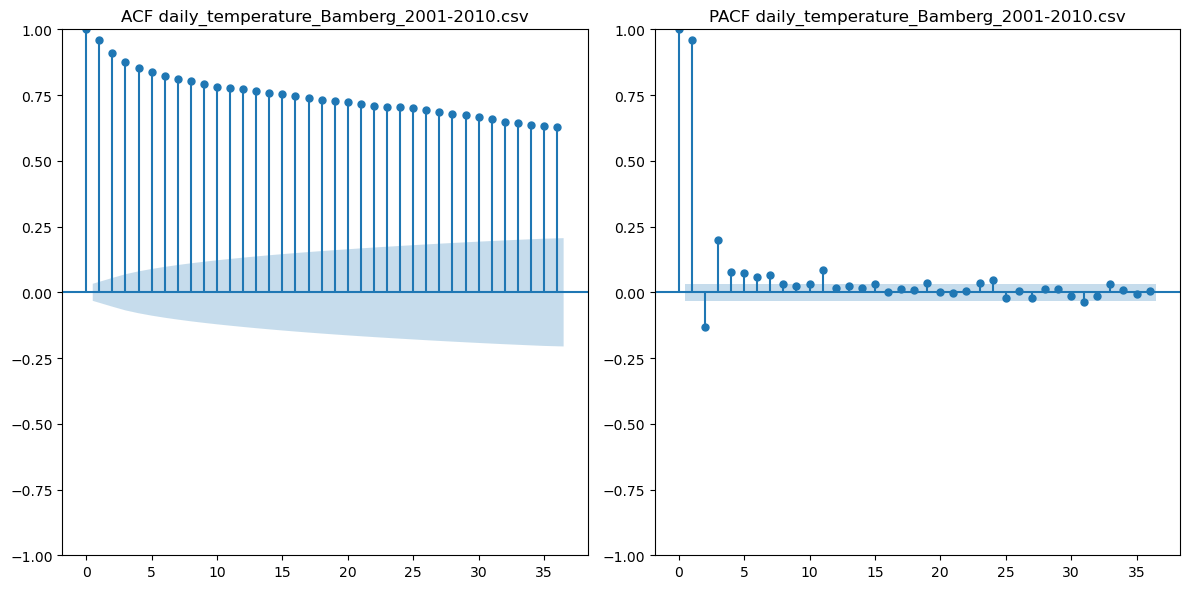

information about: daily_temperature_Bamberg_1971-1980.csv


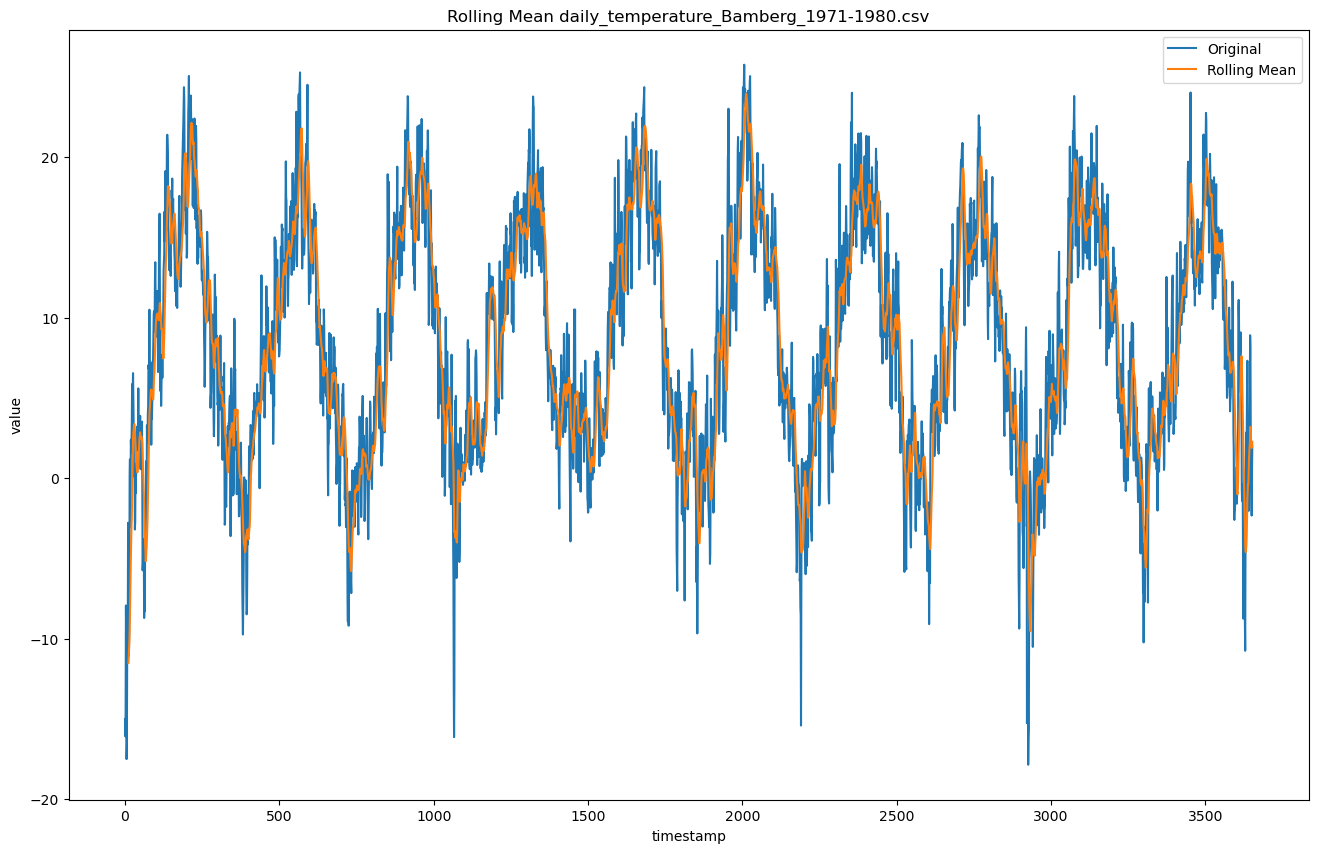

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -4.626039208424445
p-value: 0.00011562312580725506
n_lags: 14
Number of observations:3638
Critical Values:
   1%, -3.432148768574872
Critical Values:
   5%, -2.862334795726108
Critical Values:
   10%, -2.5671930819481976
ADF Statistic: 0.03489598643840635
p-value: 0.1
n_lags: 37
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


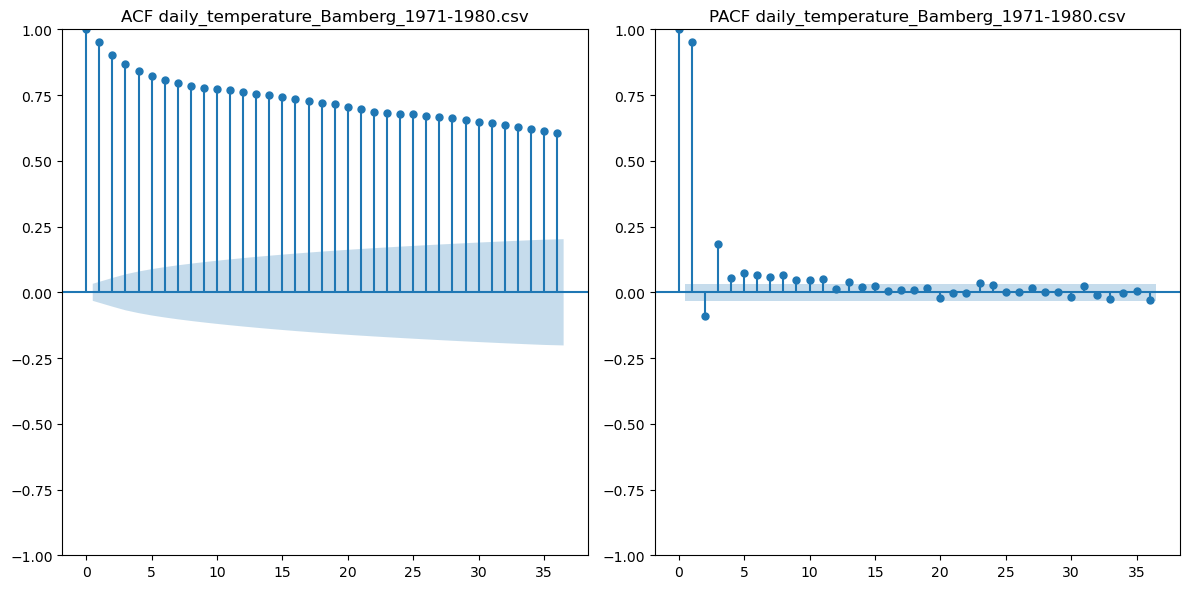

information about: daily_temperature_Bamberg_1991-2000.csv


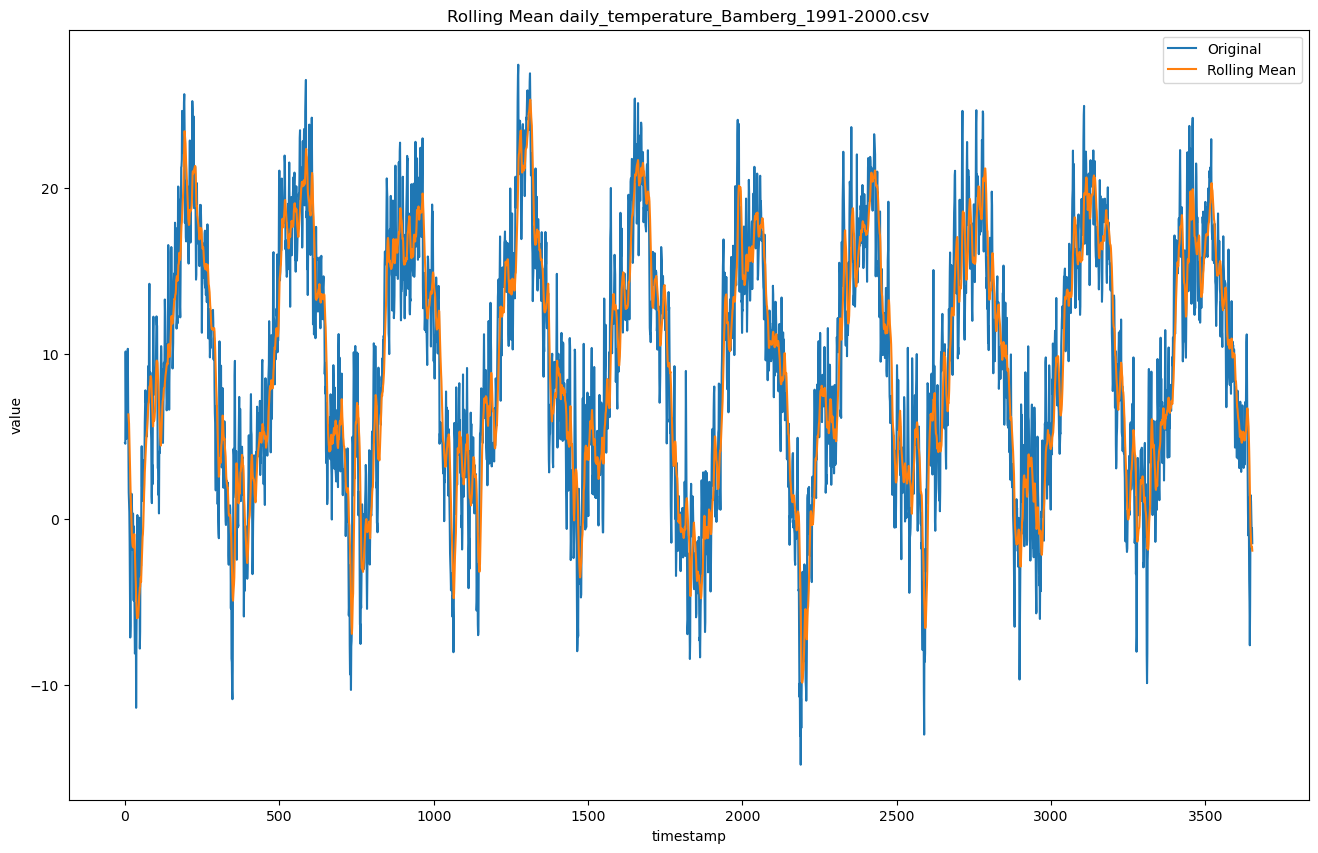

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -4.060739401767551
p-value: 0.0011238141282031195
n_lags: 15
Number of observations:3637
Critical Values:
   1%, -3.432149263499404
Critical Values:
   5%, -2.8623350143451307
Critical Values:
   10%, -2.5671931983337477
ADF Statistic: 0.045255252239128275
p-value: 0.1
n_lags: 37
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


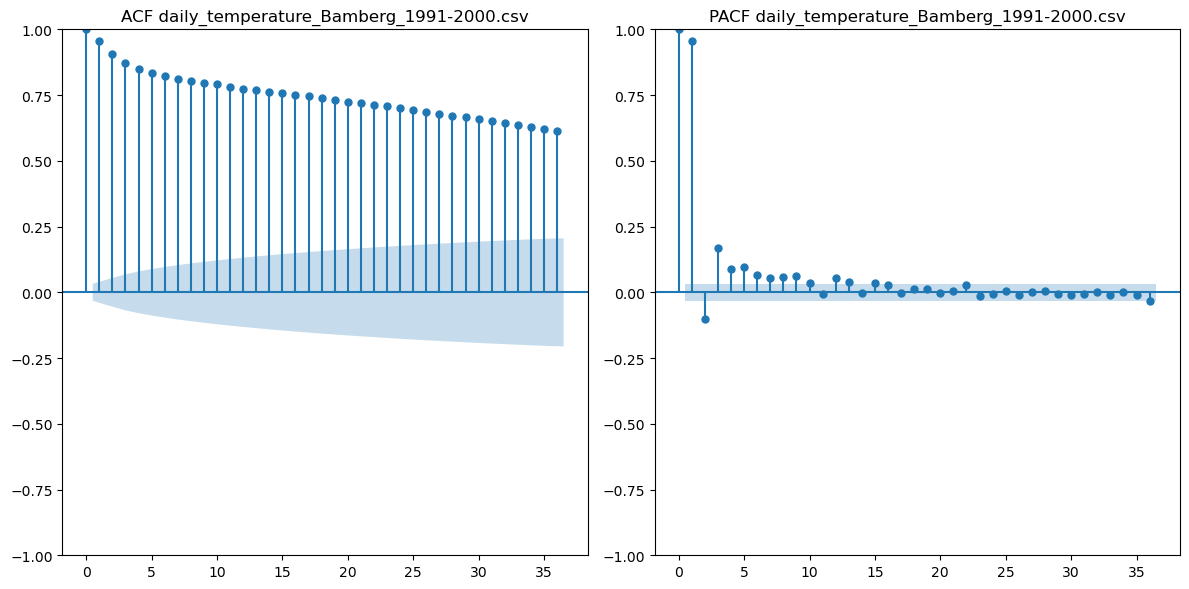

In [9]:
#become file lists
csv_files = glob.glob("Temperature/*.csv")

#summary for all daily_temperature signals
file_names = [os.path.basename(file) for file in csv_files 
                if os.path.basename(file) != 'temperature_Bamberg.csv']
for file_name in file_names:
    df = pd.read_csv(f'Temperature/{file_name}')
    
    #rename columns to use the functions
    columnns_rename = {'MESS_DATUM':'timestamp', 'TT_TU':'value'}
    df_new = df.rename(columns=columnns_rename)

    #impute missing value using simple imputer
    imp = SimpleImputer()
    imp.fit(df_new[['value']])
    df_new['value'] = imp.transform(df_new[['value']])
    print_information_about_file(df_new, file_name)

In [10]:
#create a summary information

for i in range(len(regression_ADF_values)):
    regression_ADF = regression_ADF_values[i]
    regression_KPSS = regression_KPSS_values[i]
    for file_name in file_names:
        df = pd.read_csv(f'Temperature/{file_name}')
        
        #rename columns to use the functions
        columnns_rename = {'MESS_DATUM':'timestamp', 'TT_TU':'value'}
        df_new = df.rename(columns=columnns_rename)
        
        #impute missing value using simple imputer
        imp = SimpleImputer()
        imp.fit(df_new[['value']])
        df_new['value'] = imp.transform(df_new[['value']])
        df_info = create_summary_frame(df_info, df_new, file_name, regression_ADF, regression_KPSS)

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)
/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/1037746295.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_info = df_info.append({'File Name': file_name,
/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)
/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/1037746295.py:13: FutureWarning: The frame.append method is deprecated and will be re

In [11]:
#save the information as a .csv file
df_info.to_csv('Summary/temperature_summary.csv', index=False)

Pressure collection

In [12]:
#create a new info_frame
columns = ['File Name', 'Length', 'ADF Statistic', 'ADF Regression', 'ADF p-value', 'ADF lags', 'ADF Critical Value 10%', 'ADF Critical Value 5%', 'KPSS Statistics', 'KPSS Regression', 'KPSS p-value', 'KPSS Critical Value 10%', 'KPSS Critical Value 5%']
df_info = pd.DataFrame(columns=columns)
regression_ADF_values = ['c', 'n', 'ct', 'ctt']
regression_KPSS_values = ['c', 'c', 'ct', 'ct']

information about: daily_pressure_training.csv


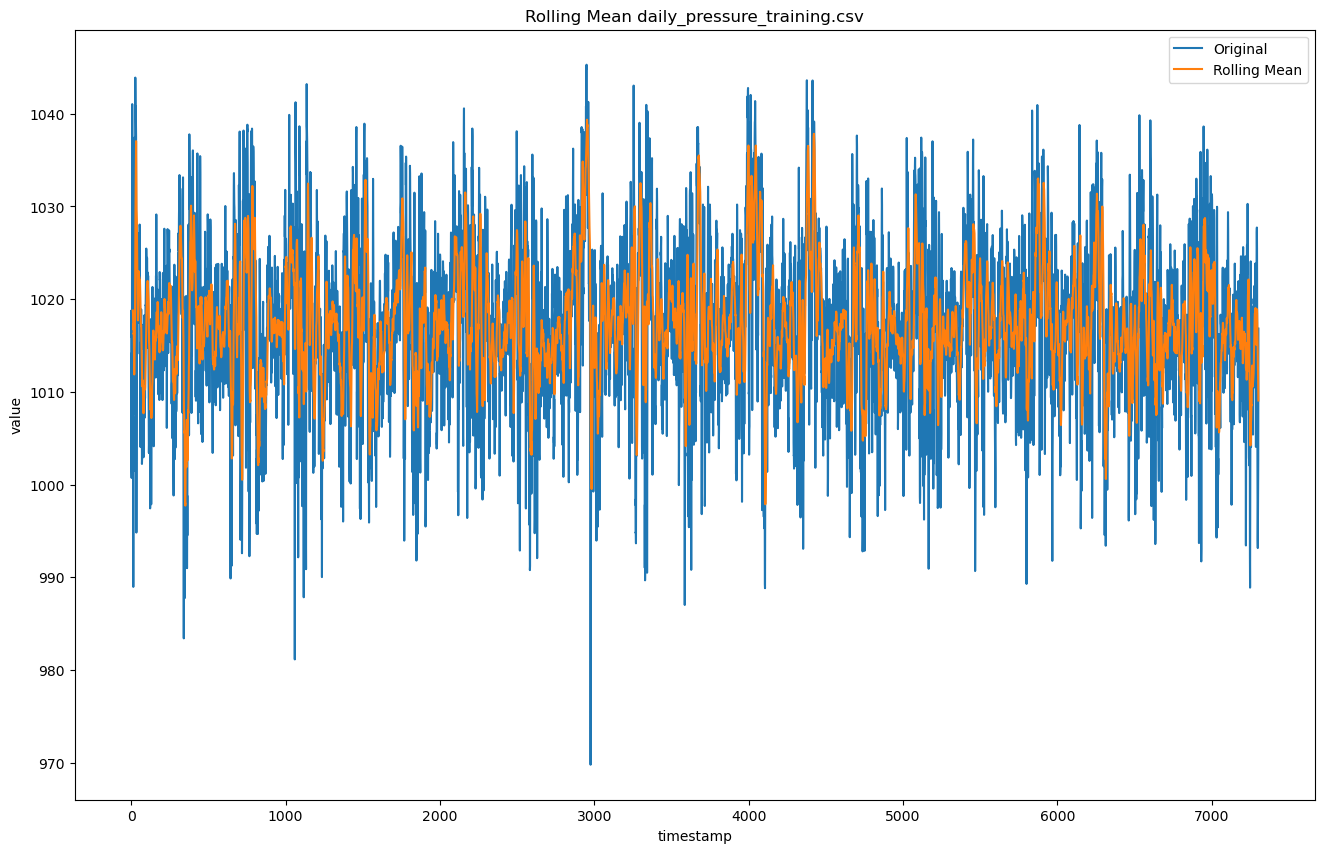

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -17.414769625789916
p-value: 4.8631919913655054e-30
n_lags: 12
Number of observations:7290
Critical Values:
   1%, -3.4312473393828506
Critical Values:
   5%, -2.861936554396301
Critical Values:
   10%, -2.566981081662875
ADF Statistic: 0.1107936505063732
p-value: 0.1
n_lags: 40
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


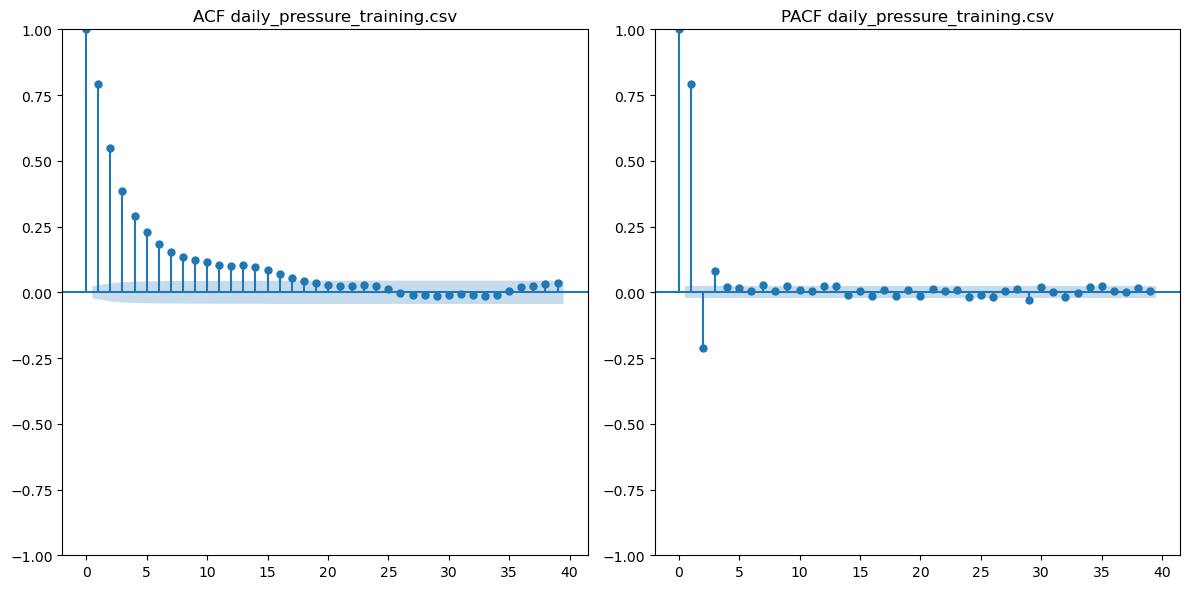

information about: daily_pressure_test2.csv


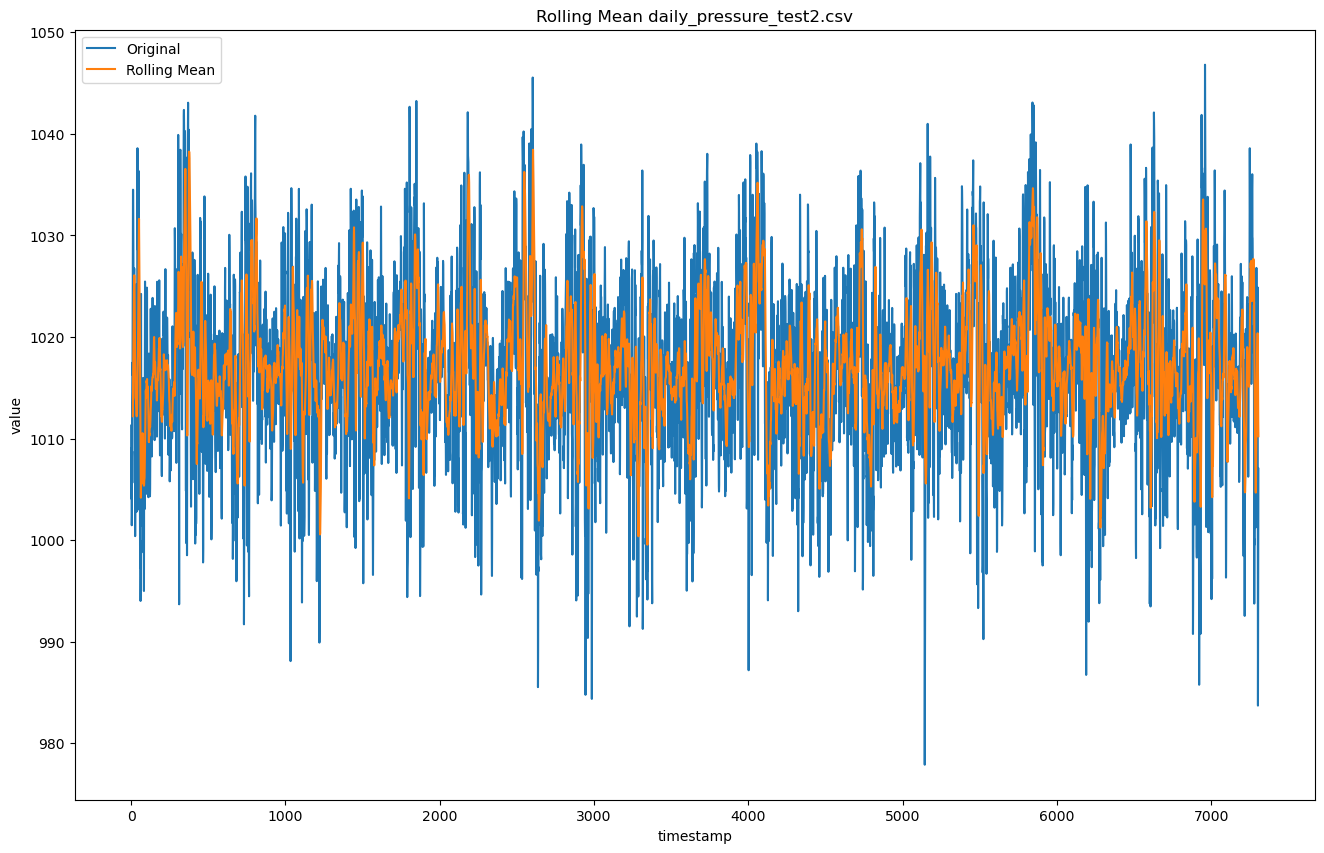

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -28.002345848845064
p-value: 0.0
n_lags: 3
Number of observations:7301
Critical Values:
   1%, -3.4312459869370326
Critical Values:
   5%, -2.8619359568102607
Critical Values:
   10%, -2.5669807635586652
ADF Statistic: 0.05372616004464948
p-value: 0.1
n_lags: 38
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


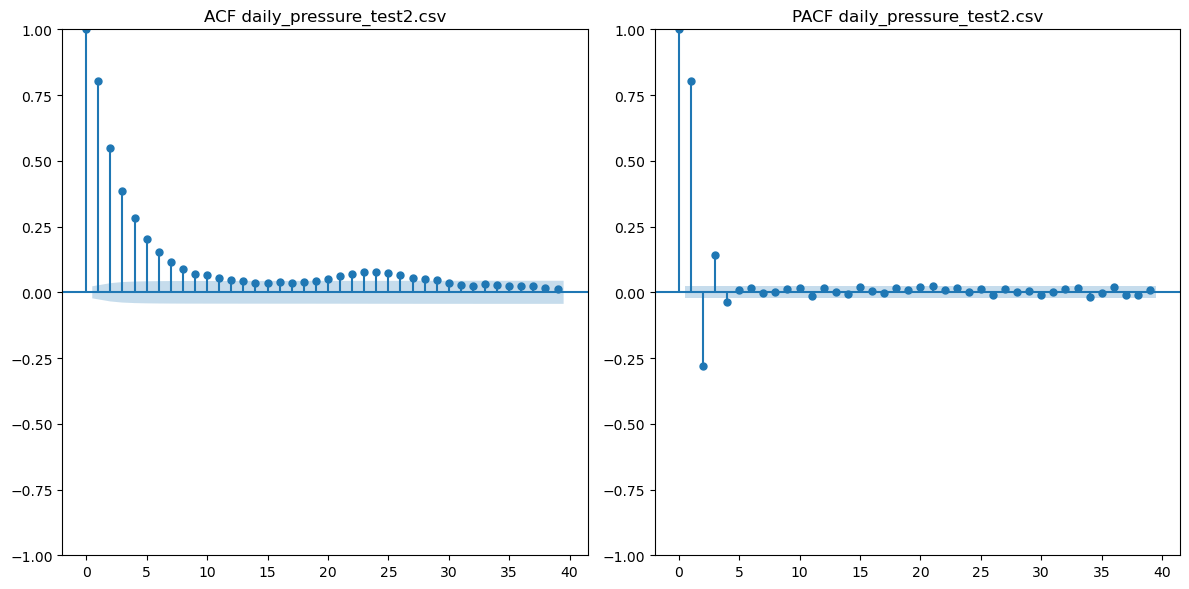

information about: daily_pressure_test1.csv


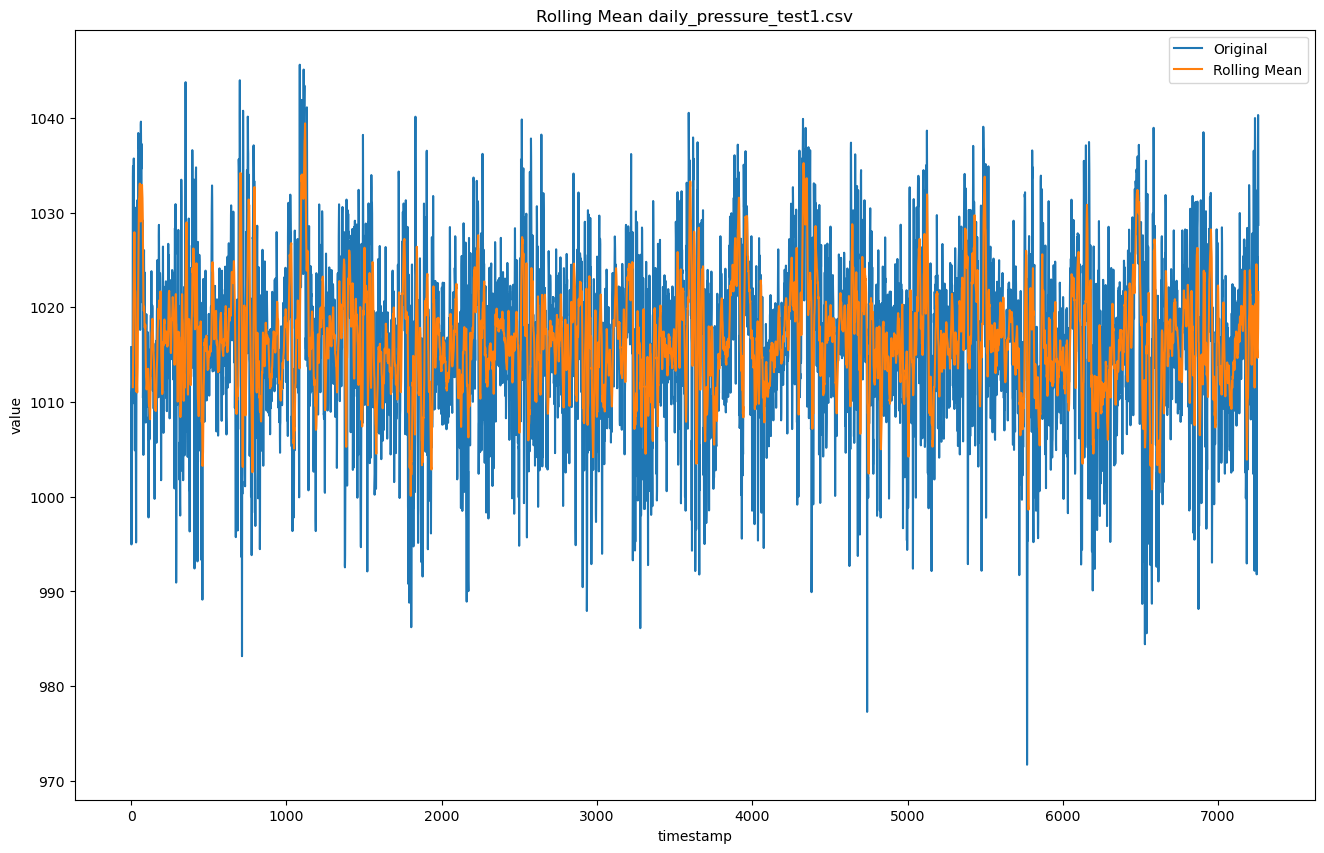

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -26.45157436052378
p-value: 0.0
n_lags: 4
Number of observations:7256
Critical Values:
   1%, -3.4312515456042614
Critical Values:
   5%, -2.861938412937926
Critical Values:
   10%, -2.56698207099337
ADF Statistic: 0.11686158504759067
p-value: 0.1
n_lags: 38
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


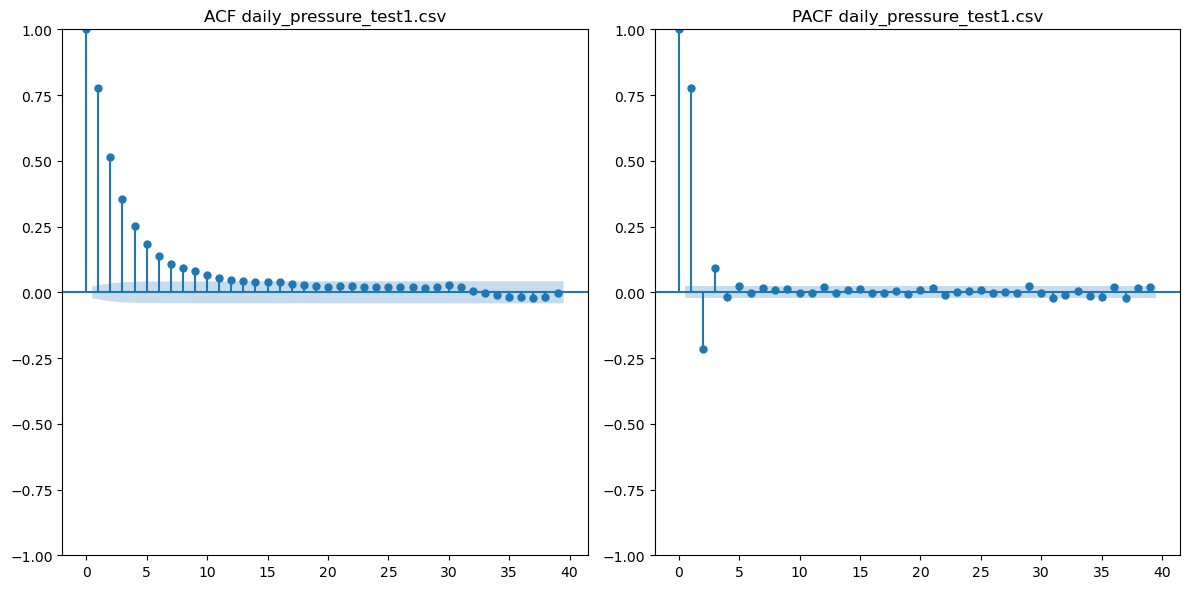

information about: daily_pressure_Bamberg_1961-1970.csv


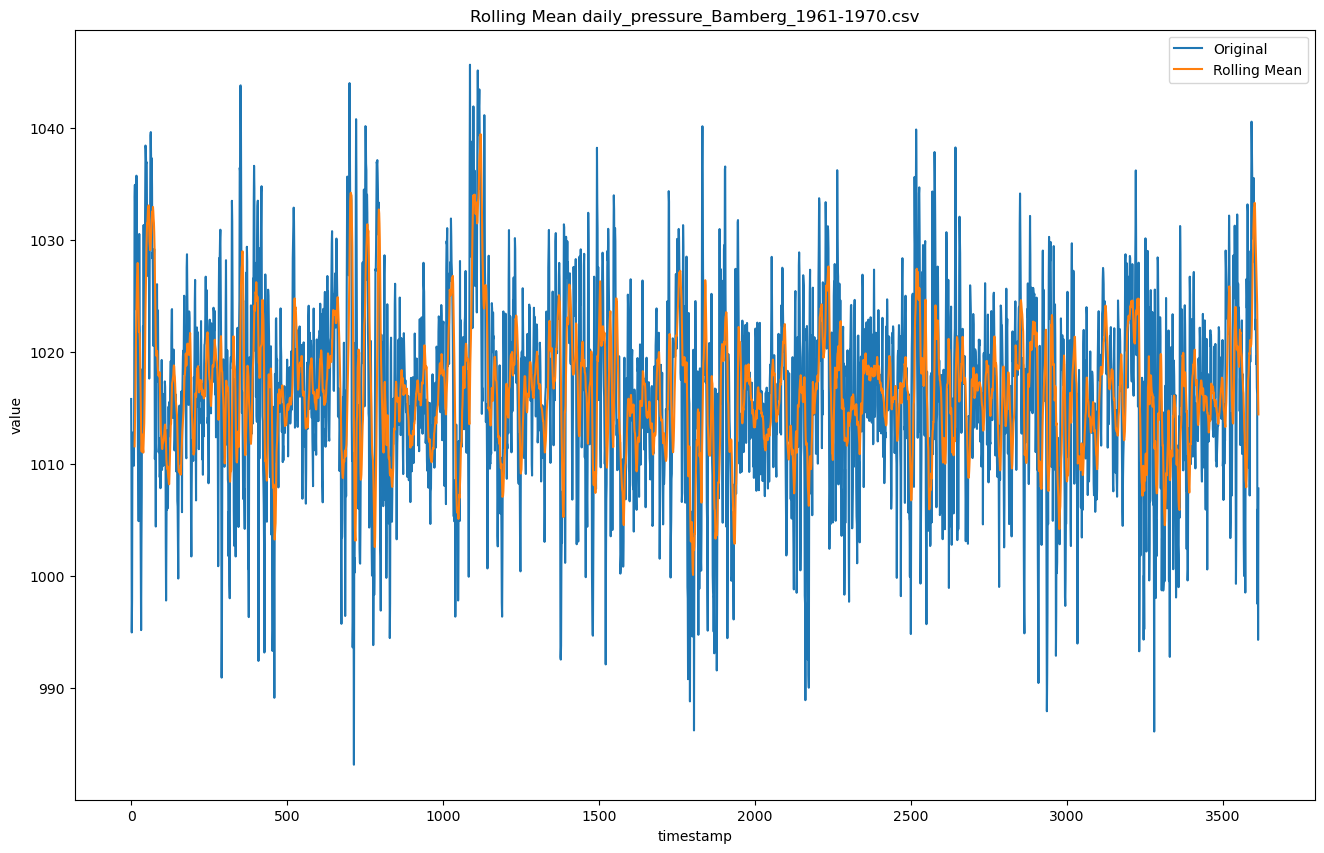

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -16.286774174529196
p-value: 3.369386058107534e-29
n_lags: 7
Number of observations:3606
Critical Values:
   1%, -3.4321647424093515
Critical Values:
   5%, -2.8623418517008936
Critical Values:
   10%, -2.567196838319323
ADF Statistic: 0.3436430156180303
p-value: 0.1
n_lags: 27
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


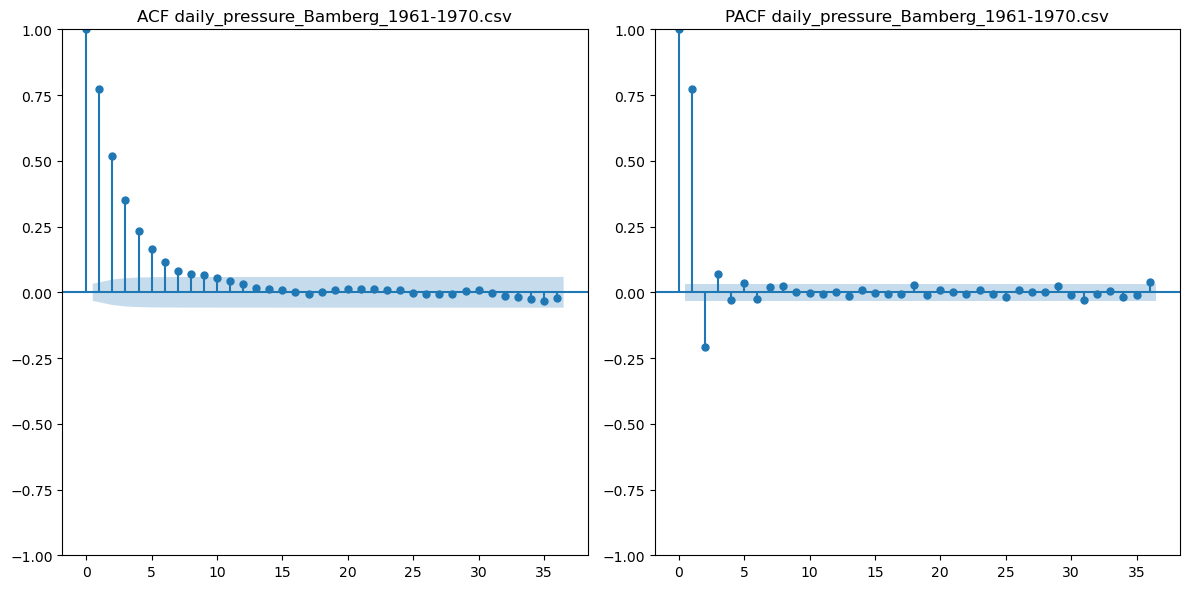

information about: daily_pressure_Bamberg_1981-1990.csv


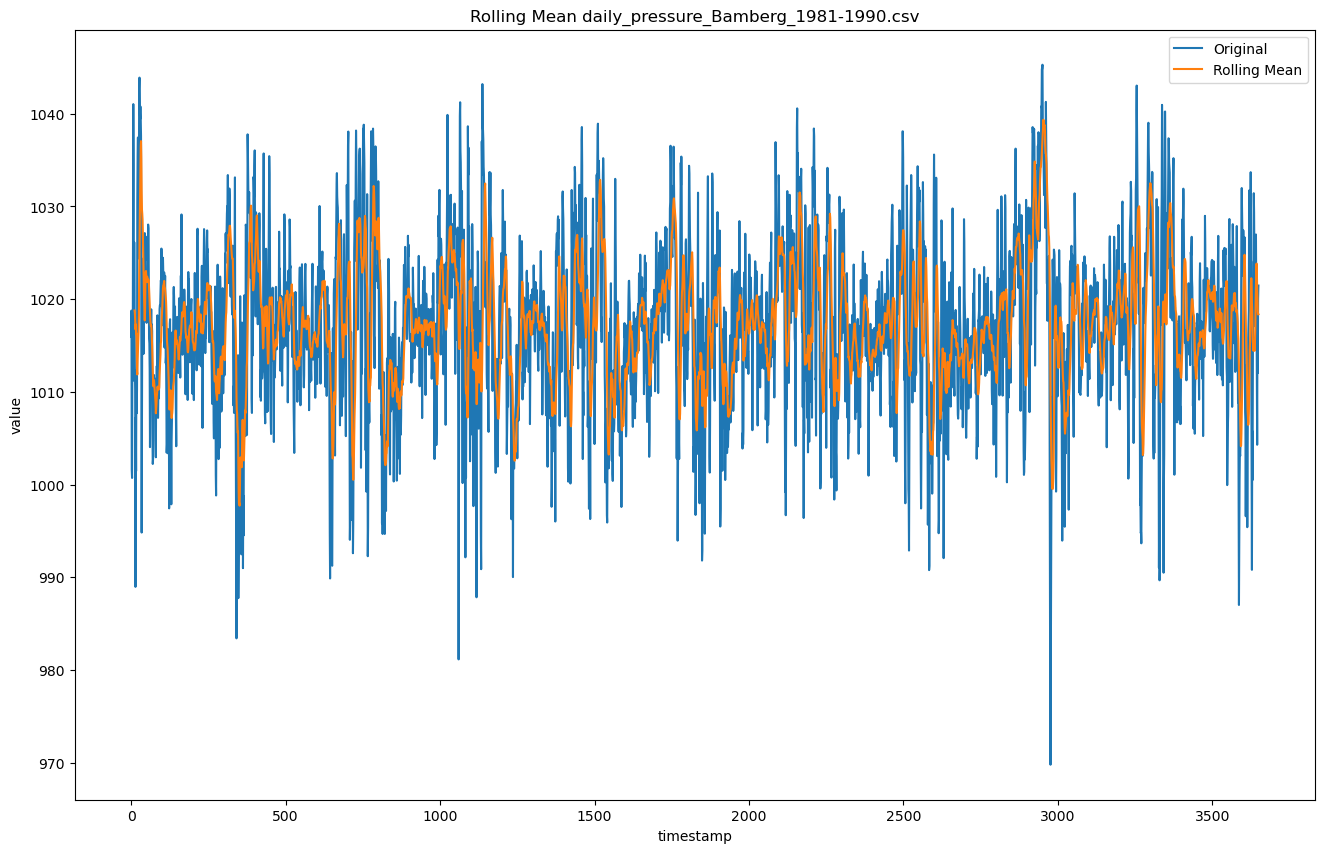

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -20.686700822549813
p-value: 0.0
n_lags: 2
Number of observations:3647
Critical Values:
   1%, -3.4321443264763563
Critical Values:
   5%, -2.8623328335521245
Critical Values:
   10%, -2.5671920373518233
ADF Statistic: 0.14961135426484895
p-value: 0.1
n_lags: 29
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


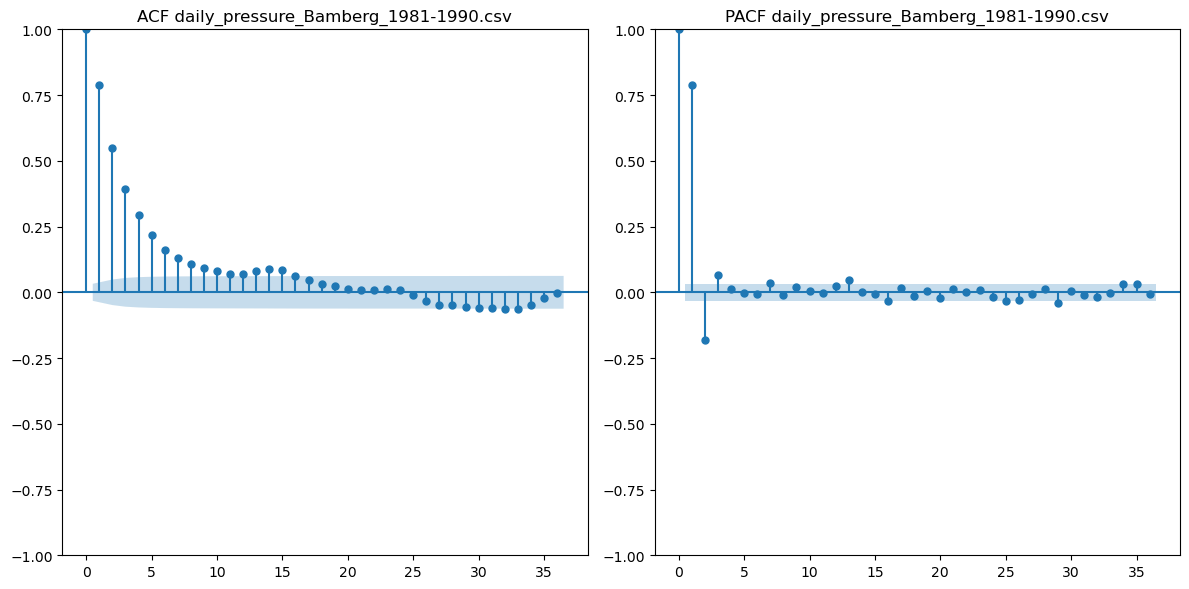

information about: daily_pressure_Bamberg_2011-2020.csv


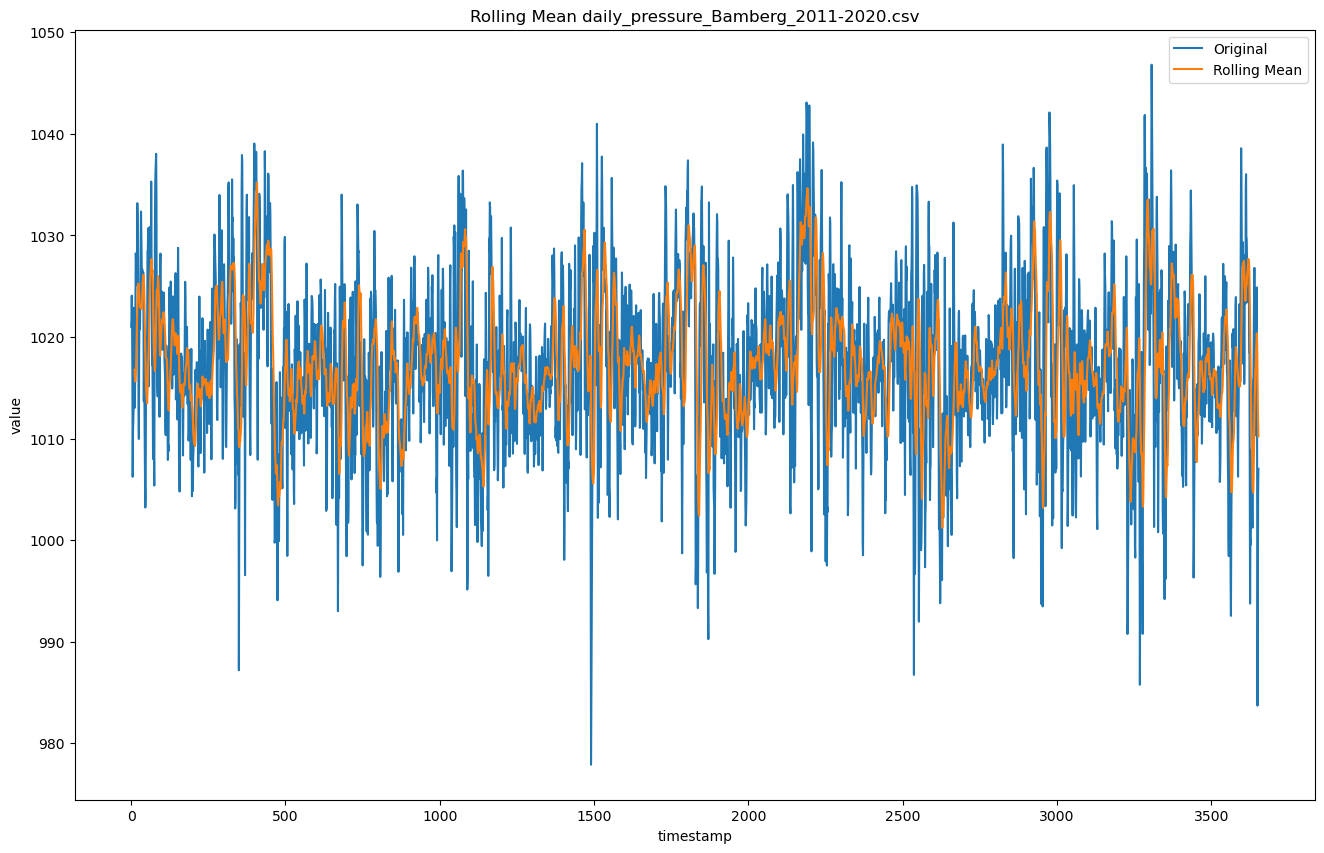

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -19.615903543800133
p-value: 0.0
n_lags: 3
Number of observations:3649
Critical Values:
   1%, -3.4321433423211882
Critical Values:
   5%, -2.862332398828442
Critical Values:
   10%, -2.567191805919415
ADF Statistic: 0.09970652360488123
p-value: 0.1
n_lags: 29
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


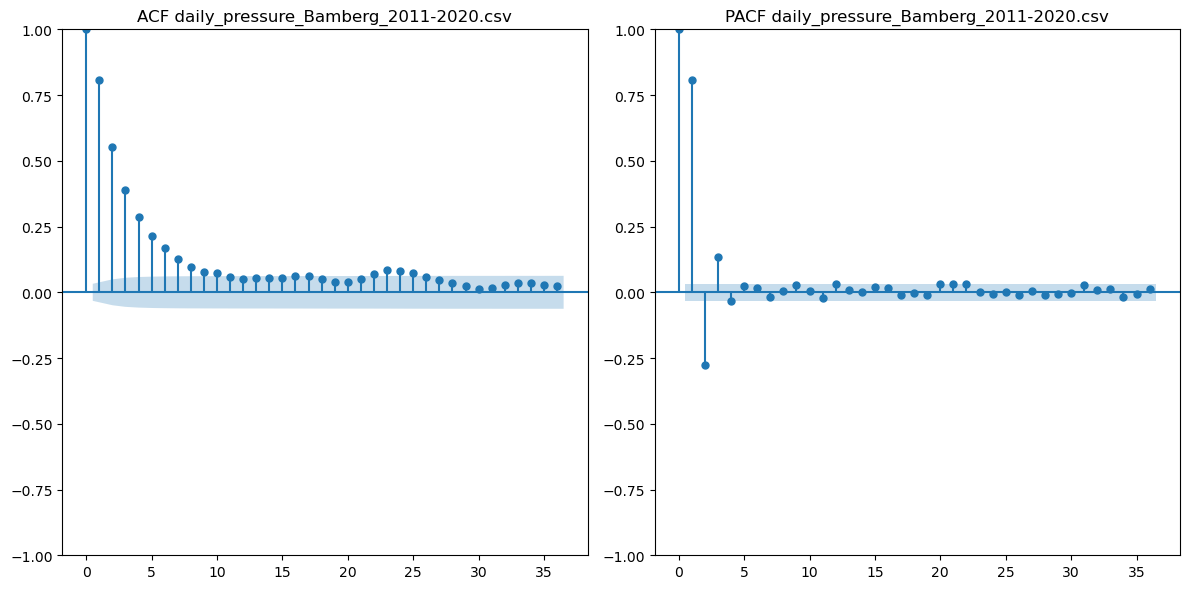

information about: daily_pressure_Bamberg_1991-2000.csv


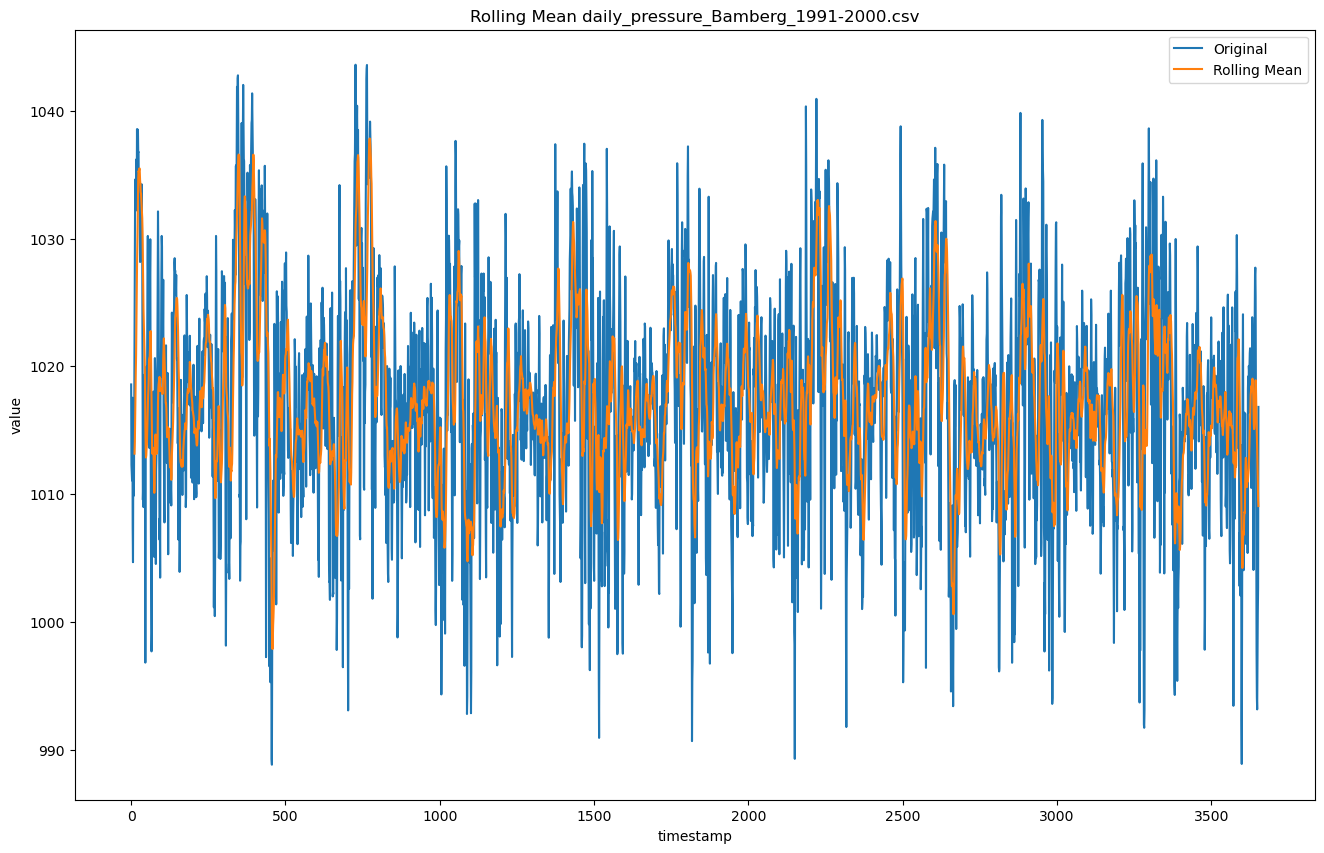

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -17.465995018975107
p-value: 4.569958897841119e-30
n_lags: 4
Number of observations:3648
Critical Values:
   1%, -3.4321438342637873
Critical Values:
   5%, -2.8623326161306752
Critical Values:
   10%, -2.5671919216038828
ADF Statistic: 0.3295396779879539
p-value: 0.1
n_lags: 30
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


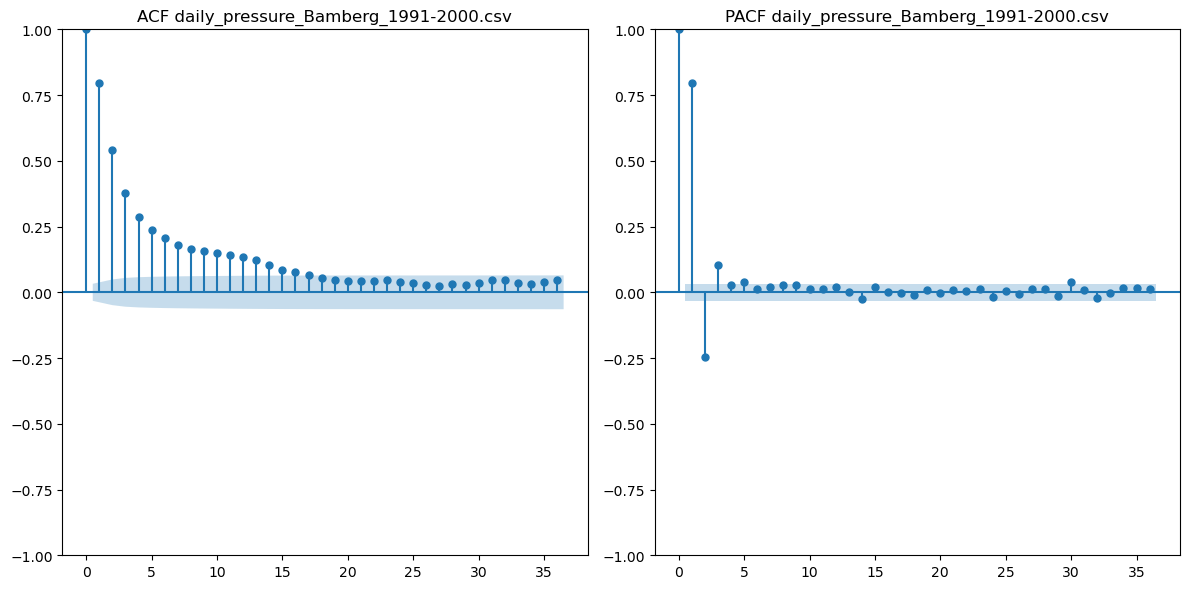

information about: daily_pressure_Bamberg_1971-1980.csv


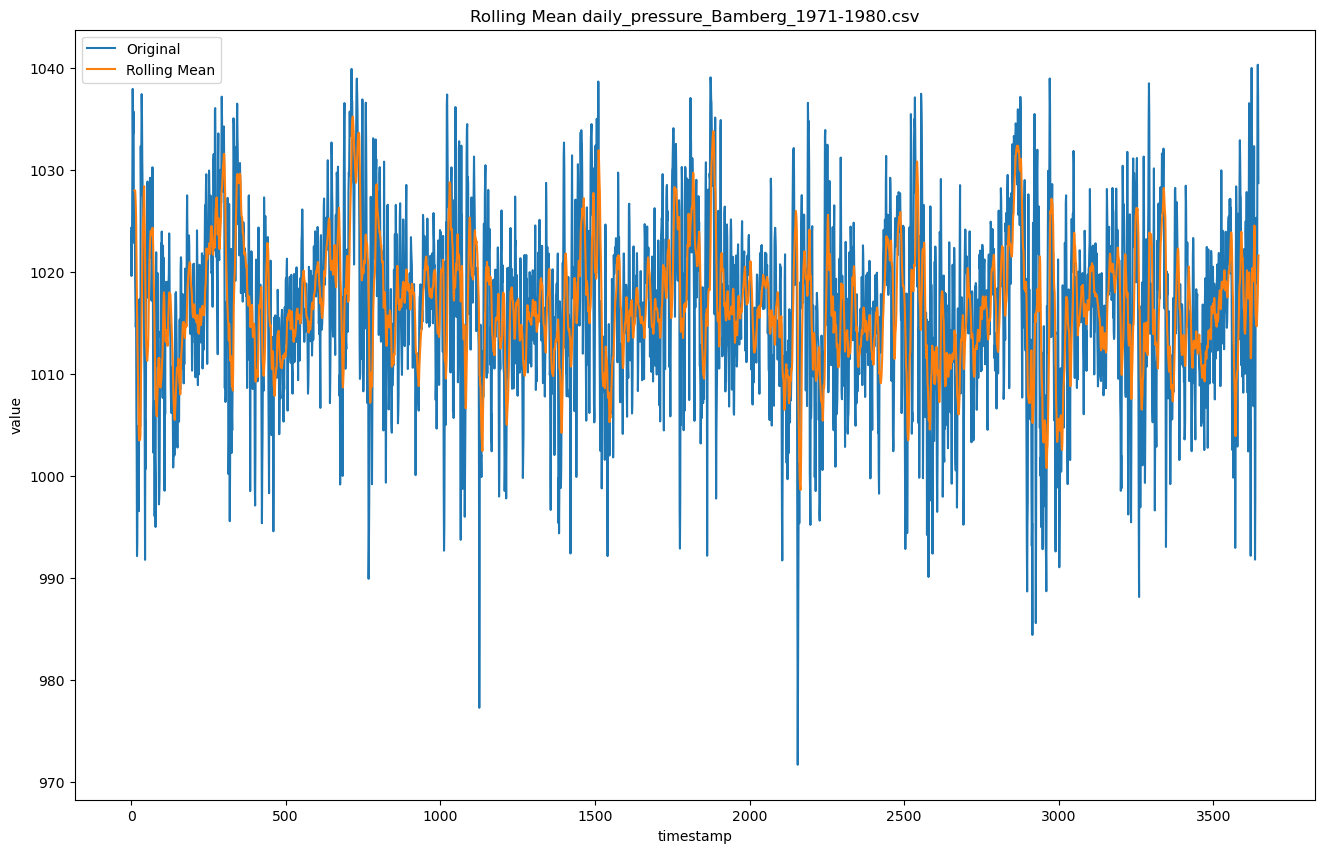

ADF Statistic: -20.72533343450095
p-value: 0.0
n_lags: 2
Number of observations:3644
Critical Values:
   1%, -3.4321458047361055
Critical Values:
   5%, -2.8623334865327488
Critical Values:
   10%, -2.567192384977004
ADF Statistic: 0.3888187056614077
p-value: 0.08197469583560013
n_lags: 29
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


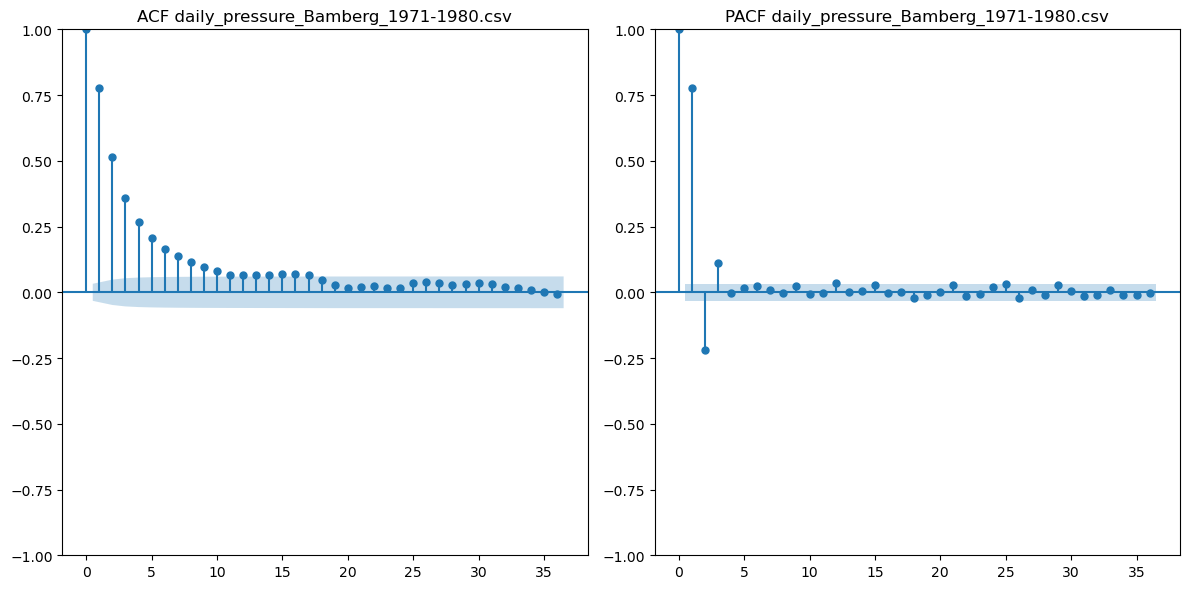

information about: daily_pressure_Bamberg.csv


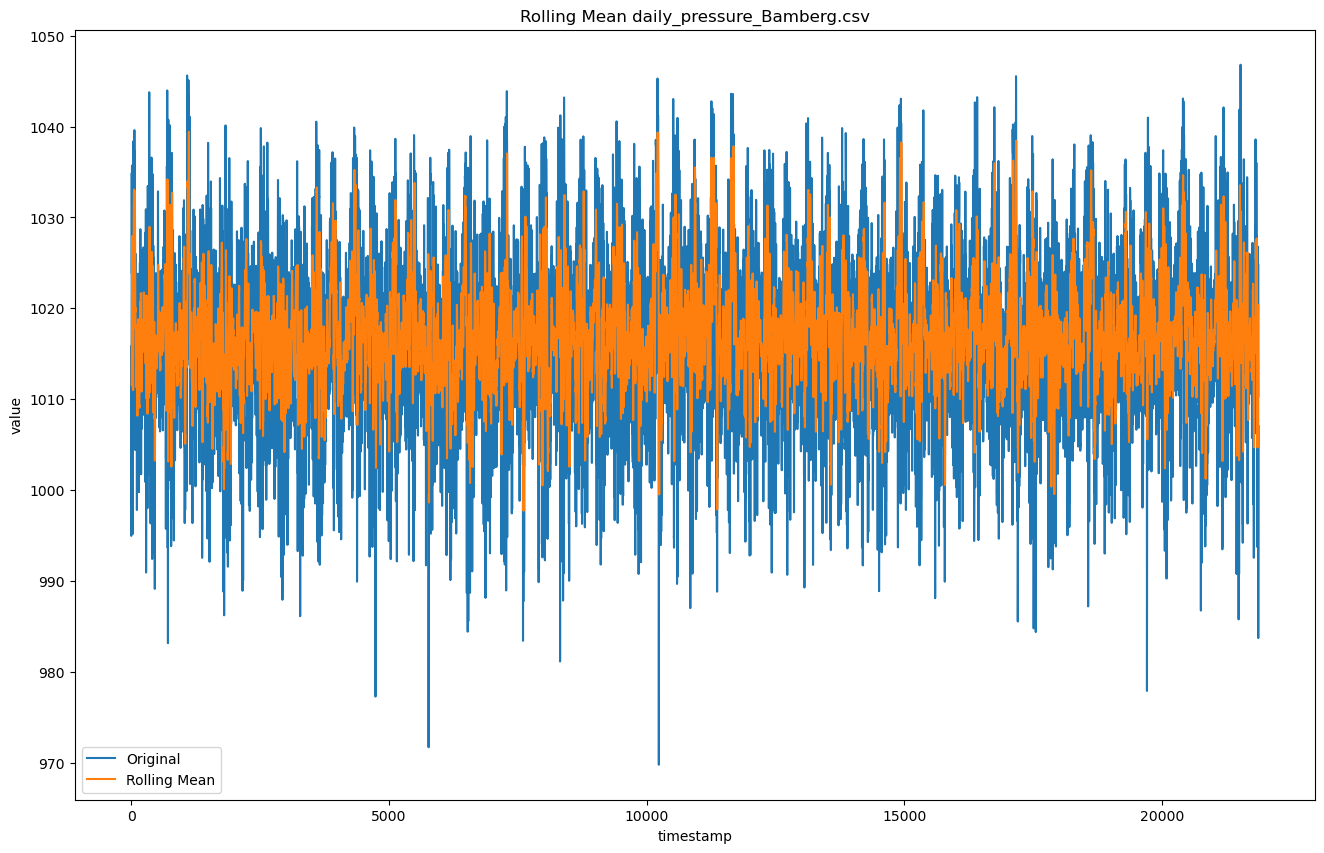

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -33.15519475468507
p-value: 0.0
n_lags: 11
Number of observations:21857
Critical Values:
   1%, -3.4306492207603156
Critical Values:
   5%, -2.8616722456786157
Critical Values:
   10%, -2.566840390653666
ADF Statistic: 0.25529690115204234
p-value: 0.1
n_lags: 62
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


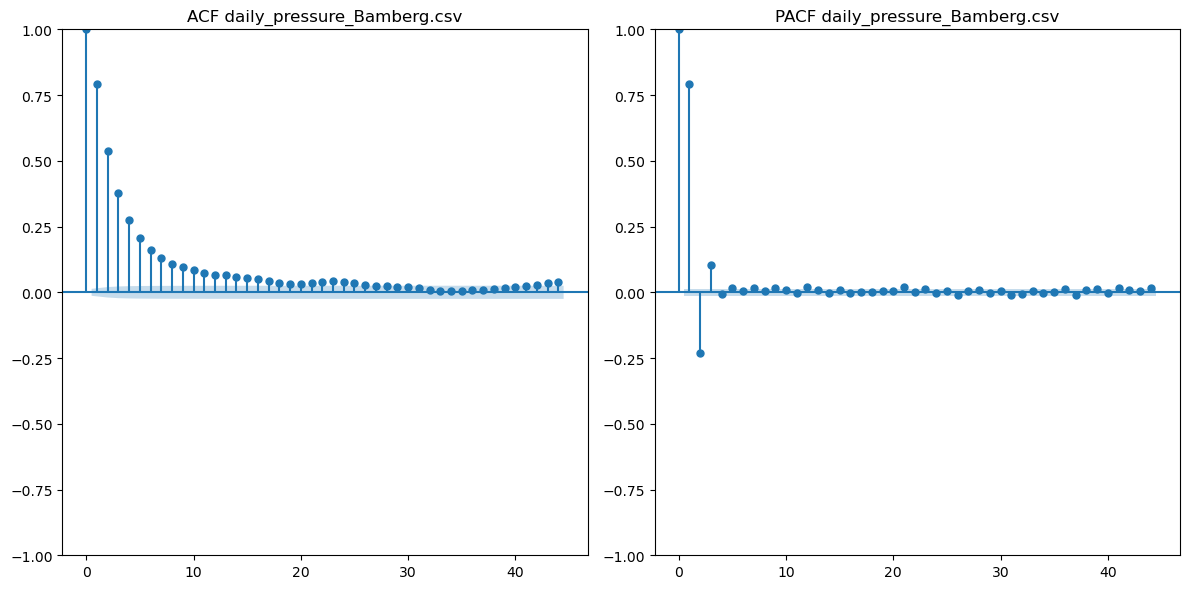

information about: daily_pressure_Bamberg_2001-2010.csv


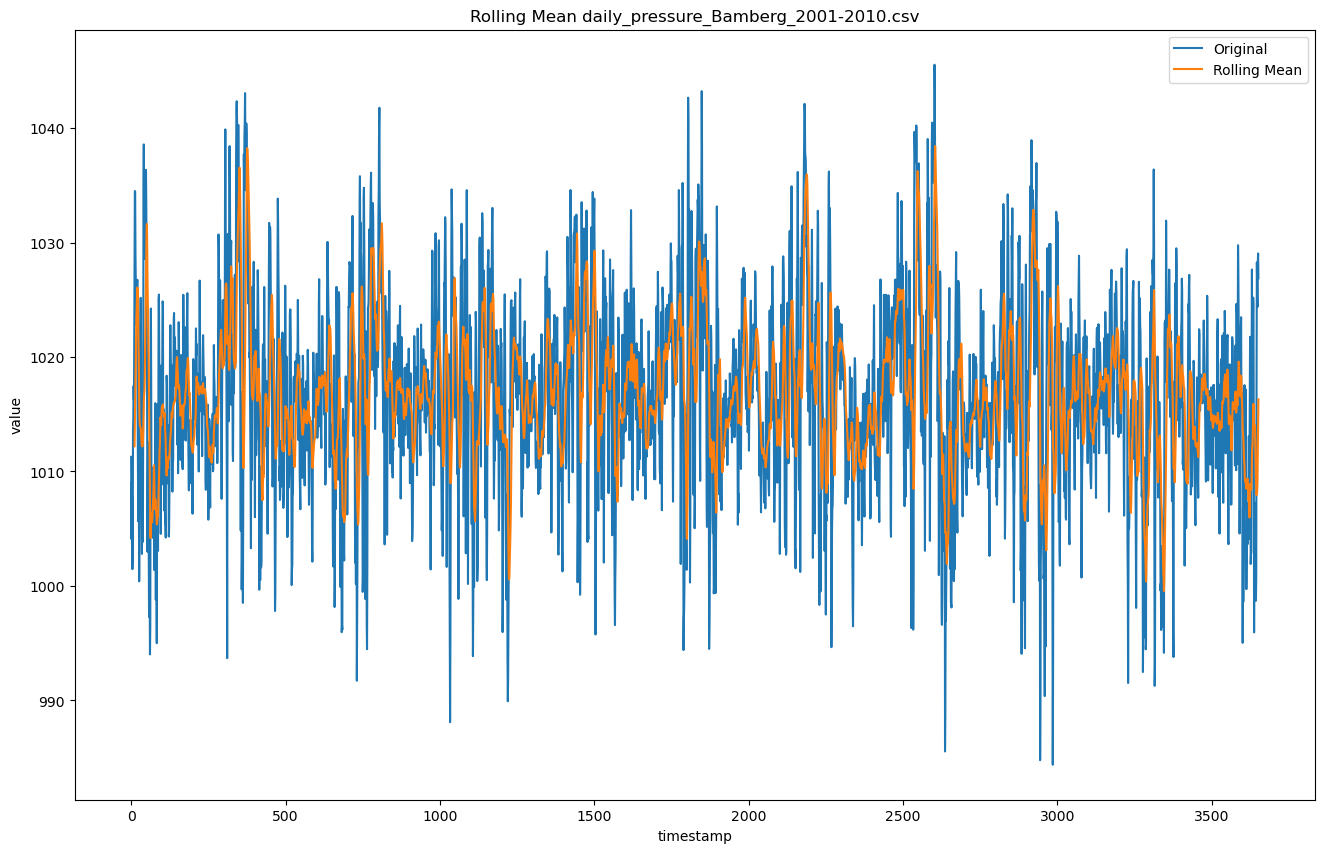

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -19.975331383480736
p-value: 0.0
n_lags: 3
Number of observations:3648
Critical Values:
   1%, -3.4321438342637873
Critical Values:
   5%, -2.8623326161306752
Critical Values:
   10%, -2.5671919216038828
ADF Statistic: 0.266286636693702
p-value: 0.1
n_lags: 28
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


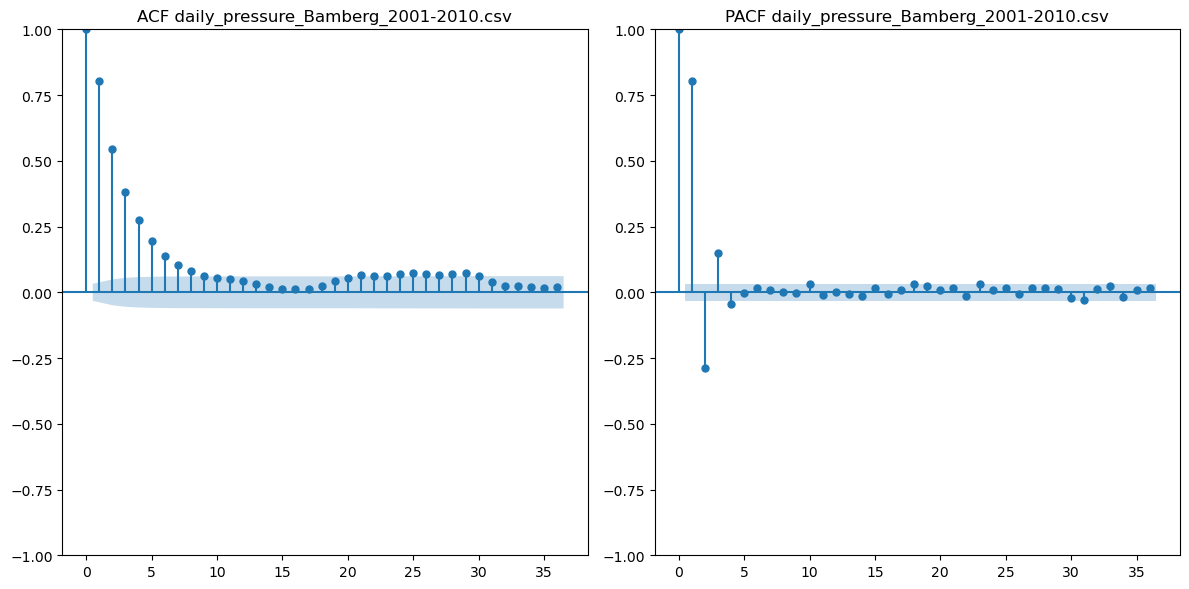

In [13]:
#become file lists
csv_files = glob.glob("Pressure/*.csv")
file_names = [os.path.basename(file) for file in csv_files 
                if os.path.basename(file) != 'pressure_Bamberg.csv']
                
for file_name in file_names:
    df = pd.read_csv(f'Pressure/{file_name}')

    #rename columns to use the functions
    columnns_rename = {'MESS_DATUM':'timestamp', 'P':'value'}
    df_new = df.rename(columns=columnns_rename)

    #impute missing value using simple imputer
    imp = SimpleImputer()
    imp.fit(df_new[['value']])
    df_new['value'] = imp.transform(df_new[['value']])
    print_information_about_file(df_new, file_name)

In [14]:
#create a summary information

for i in range(len(regression_ADF_values)):
    regression_ADF = regression_ADF_values[i]
    regression_KPSS = regression_KPSS_values[i]
    for file_name in file_names:
        df = pd.read_csv(f'Pressure/{file_name}')

        #rename columns to use the functions
        columnns_rename = {'MESS_DATUM':'timestamp', 'P':'value'}
        df_new = df.rename(columns=columnns_rename)
        
        #impute missing value using simple imputer
        imp = SimpleImputer()
        imp.fit(df_new[['value']])
        df_new['value'] = imp.transform(df_new[['value']])
        df_info = create_summary_frame(df_info, df_new, file_name, regression_ADF, regression_KPSS)

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)
/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/1037746295.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_info = df_info.append({'File Name': file_name,
/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/2183033942.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)
/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_7896/1037746295.py:13: FutureWarning: The frame.append method is deprecated and will be re

In [15]:
#save the information as a .csv file
df_info.to_csv('Summary/pressure_summary.csv', index=False)

## Check the stationarity of signals from the pressure and temperature collections of the Weather Dataset

Stationarity was assessed using a singular ADF test with various regression parameters and a combination of ADF and KPSS tests. The null hypothesis is rejected when the p-value is less than 0.5

Necessary functions.

In [22]:
def display_stationary_files_ADF(df, regression_type, p_value_threshold=0.05):
    """
    Display files from a DataFrame that meet stationary criteria based on the ADF test.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    regression_type (str): The type of ADF regression ('n', 'ctt', 'ct', 'c').
    p_value_threshold (float, optional): The p-value threshold for considering a file as stationary. Default is 0.05.
    """
    stationary_files = df[((df['ADF Regression'] == regression_type) & (df['ADF p-value'] < p_value_threshold))]
    print(f"Number of stationary files for '{regression_type}': {len(stationary_files)}")
    print(stationary_files['File Name'].head(20))


In [29]:
def filter_and_print_stationary_files(df):
    """
    Filter and print file names based on stationary criteria using ADF and KPSS tests.

    Parameters:
    df (DataFrame): The DataFrame containing the data.

    Returns:
    None
    """

    ts_stationary_c = df[((df['KPSS Regression'] == 'c') & (df['KPSS p-value'] >= 0.05)) & (df['ADF Regression'] == 'c') & (df['ADF p-value'] < 0.05)]
    ts_stationary_ct = df[((df['KPSS Regression'] == 'ct') & (df['KPSS p-value'] >= 0.05)) & (df['ADF Regression'] == 'ct') & (df['ADF p-value'] < 0.05)]
    stationary_ct = df[((df['KPSS Regression'] == 'ct') & (df['KPSS p-value'] < 0.05)) & (df['ADF Regression'] == 'ct') & (df['ADF p-value'] < 0.05)]
    stationary_c = df[((df['KPSS Regression'] == 'c') & (df['KPSS p-value'] < 0.05)) & (df['ADF Regression'] == 'c') & (df['ADF p-value'] < 0.05)]
    ds_stationary_c = df[((df['KPSS Regression'] == 'c') & (df['KPSS p-value'] < 0.05)) & (df['ADF Regression'] == 'c') & (df['ADF p-value'] >= 0.05)]
    ds_stationary_ct = df[((df['KPSS Regression'] == 'ct') & (df['KPSS p-value'] < 0.05)) & (df['ADF Regression'] == 'ct') & (df['ADF p-value'] >= 0.05)]

    print("TS-Stationary_c:")
    print(ts_stationary_c['File Name'])
    print("\nTS-Stationary_ct:")
    print(ts_stationary_ct['File Name'])
    print("\nStationary_ct:")
    print(stationary_ct['File Name'])
    print("\nStationary_c:")
    print(stationary_c['File Name'])
    print("\nDS-Stationary_c:")
    print(ds_stationary_c['File Name'])
    print("\nDS-Stationary_ct:")
    print(ds_stationary_ct['File Name'])


Temperature collection

In [32]:
#read the .csv file with summary information.
temp = pd.read_csv('Summary/temperature_summary.csv')

In [33]:
#use function for each regression parameter 
display_stationary_files_ADF(temp, 'n') #no constant, no thend
display_stationary_files_ADF(temp, 'ctt') #constant and quadratic trend
display_stationary_files_ADF(temp, 'ct') #constant and linear trend
display_stationary_files_ADF(temp, 'c') #constant only

Number of stationary files for 'n': 10
10              daily_temperature_Bamberg.csv
11    daily_temperature_Bamberg_1981-1990.csv
12    daily_temperature_Bamberg_1961-1970.csv
13    daily_temperature_Bamberg_2011-2020.csv
14                daily_temperature_test1.csv
15             daily_temperature_training.csv
16                daily_temperature_test2.csv
17    daily_temperature_Bamberg_2001-2010.csv
18    daily_temperature_Bamberg_1971-1980.csv
19    daily_temperature_Bamberg_1991-2000.csv
Name: File Name, dtype: object
Number of stationary files for 'ctt': 7
30              daily_temperature_Bamberg.csv
31    daily_temperature_Bamberg_1981-1990.csv
34                daily_temperature_test1.csv
35             daily_temperature_training.csv
36                daily_temperature_test2.csv
38    daily_temperature_Bamberg_1971-1980.csv
39    daily_temperature_Bamberg_1991-2000.csv
Name: File Name, dtype: object
Number of stationary files for 'ct': 10
20              daily_temperature_Bam

In [34]:
#print summary for a stationarity using ADF and KPSS tests
filter_and_print_stationary_files(temp)

TS-Stationary_c:
0              daily_temperature_Bamberg.csv
1    daily_temperature_Bamberg_1981-1990.csv
2    daily_temperature_Bamberg_1961-1970.csv
3    daily_temperature_Bamberg_2011-2020.csv
4                daily_temperature_test1.csv
5             daily_temperature_training.csv
6                daily_temperature_test2.csv
7    daily_temperature_Bamberg_2001-2010.csv
8    daily_temperature_Bamberg_1971-1980.csv
9    daily_temperature_Bamberg_1991-2000.csv
Name: File Name, dtype: object

TS-Stationary_ct:
20              daily_temperature_Bamberg.csv
21    daily_temperature_Bamberg_1981-1990.csv
22    daily_temperature_Bamberg_1961-1970.csv
23    daily_temperature_Bamberg_2011-2020.csv
24                daily_temperature_test1.csv
25             daily_temperature_training.csv
26                daily_temperature_test2.csv
27    daily_temperature_Bamberg_2001-2010.csv
28    daily_temperature_Bamberg_1971-1980.csv
29    daily_temperature_Bamberg_1991-2000.csv
Name: File Name, dtype:

Pressure collection

In [23]:
#read the .csv file with summary information.
pr = pd.read_csv('Summary/pressure_summary.csv')

In [24]:
#use function for each regression parameter 
display_stationary_files_ADF(pr, 'n') #no constant, no thend
display_stationary_files_ADF(pr, 'ctt') #constant and quadratic trend
display_stationary_files_ADF(pr, 'ct') #constant and linear trend
display_stationary_files_ADF(pr, 'c') #constant only

Number of stationary files for 'n': 0
Series([], Name: File Name, dtype: object)
Number of stationary files for 'ctt': 10
30             daily_pressure_training.csv
31                daily_pressure_test2.csv
32                daily_pressure_test1.csv
33    daily_pressure_Bamberg_1961-1970.csv
34    daily_pressure_Bamberg_1981-1990.csv
35    daily_pressure_Bamberg_2011-2020.csv
36    daily_pressure_Bamberg_1991-2000.csv
37    daily_pressure_Bamberg_1971-1980.csv
38              daily_pressure_Bamberg.csv
39    daily_pressure_Bamberg_2001-2010.csv
Name: File Name, dtype: object
Number of stationary files for 'ct': 10
20             daily_pressure_training.csv
21                daily_pressure_test2.csv
22                daily_pressure_test1.csv
23    daily_pressure_Bamberg_1961-1970.csv
24    daily_pressure_Bamberg_1981-1990.csv
25    daily_pressure_Bamberg_2011-2020.csv
26    daily_pressure_Bamberg_1991-2000.csv
27    daily_pressure_Bamberg_1971-1980.csv
28              daily_pressure_Ba

In [31]:
#print summary for a stationarity using ADF and KPSS tests
filter_and_print_stationary_files(pr)

TS-Stationary_c:
0             daily_pressure_training.csv
1                daily_pressure_test2.csv
2                daily_pressure_test1.csv
3    daily_pressure_Bamberg_1961-1970.csv
4    daily_pressure_Bamberg_1981-1990.csv
5    daily_pressure_Bamberg_2011-2020.csv
6    daily_pressure_Bamberg_1991-2000.csv
7    daily_pressure_Bamberg_1971-1980.csv
8              daily_pressure_Bamberg.csv
9    daily_pressure_Bamberg_2001-2010.csv
Name: File Name, dtype: object

TS-Stationary_ct:
20             daily_pressure_training.csv
21                daily_pressure_test2.csv
22                daily_pressure_test1.csv
23    daily_pressure_Bamberg_1961-1970.csv
24    daily_pressure_Bamberg_1981-1990.csv
25    daily_pressure_Bamberg_2011-2020.csv
26    daily_pressure_Bamberg_1991-2000.csv
27    daily_pressure_Bamberg_1971-1980.csv
28              daily_pressure_Bamberg.csv
29    daily_pressure_Bamberg_2001-2010.csv
Name: File Name, dtype: object

Stationary_ct:
[]

Stationary_c:
[]

DS-Stationary_